# Explorative analysis for electricity data

### By comparing measurements of electricity meters vs. data of the heatpump two models are made:
2. A model to calculate **historical** electricity consumption.  
    - For historical consumption we use the same model as described above, if `hp1.bottomPlateHeaterEnable` and `hp1.compressorCrankcaseHeaterEnable` data points are available  
    - Otherwise the model is based on outside temperature.
    > Calculation: `EstimatedPowerConsumption` = `a` + `b` * `qc.hp1PowerInput` + `c` * `hp1.getFanspeed` + `d` *  `bottomPlateHeaterEnableCalc1(t_outside)` + `e` * `bottomPlateHeaterEnableCalc2(t_outside)`  
    - Here the temperature outside is converted into two different variables which can represent the heaters behaviour for different temperatures.

3. A model to estimate heat generation

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from quatt_aws_utils.s3 import create_s3_client
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.optimize import curve_fit
import os

### Functions process data and built linear model

In [421]:
def preProcessSplitDataFrame(data_df: pd.DataFrame, y_offset=0):

    # Remove Nans
    data_df.dropna(axis=0)

    # Correct circulating pump power values
    data_df['hp1.circulatingPumpDutyCycle'] = data_df['hp1.circulatingPumpDutyCycle']*data_df['hp1.getCirculatingPumpRelay']
    # data_df['calculatedPower'] = data_df['hp1.acInputVoltage']*data_df['hp1.acInputCurrent']
    # data_df['calculatedPowerSquaredCurrent'] = data_df['hp1.acInputVoltage']*(data_df['hp1.acInputCurrent']**2)
    # data_df['calculatedPowerSquareRootCurrent'] = data_df['hp1.acInputVoltage']*(data_df['hp1.acInputCurrent']**0.5)

    # # Add non-linear power terms
    # data_df['powerSquared'] = data_df['qc.hp1PowerInput']**0.5

    # Split the data into input features (X) and target variable (y)
    # feature_cols = ['qc.hp1PowerInput', 'hp1.getFanSpeed', 'hp1.bottomPlateHeaterEnable', 'hp1.compressorCrankcaseHeaterEnable']
    feature_cols = ['qc.hp1PowerInput', 'hp1.getFanSpeed', 'hp1.temperatureOutside', 'hp1.bottomPlateHeaterEnable', 'hp1.compressorCrankcaseHeaterEnable']
    # feature_cols = ['calculatedPower', 'calculatedPowerSquaredCurrent', 'calculatedPowerSquareRootCurrent', 'hp1.getFanSpeed', 'hp1.bottomPlateHeaterEnable', 'hp1.compressorCrankcaseHeaterEnable']
    # feature_cols = ['hp1PowerInput', 'getFanSpeed']

    # Split data into train and test
    train, test = train_test_split(data_df, test_size=0.5, shuffle=False)

    X_train = train[feature_cols]
    X_test = test[feature_cols]

    # y = data['PowerIn']
    try:
        y_train = train['system.externalElectricityMeterPower'] + y_offset - train['hp1.circulatingPumpDutyCycle']
        y_test = test['system.externalElectricityMeterPower'] + y_offset - test['hp1.circulatingPumpDutyCycle']
        energy_train = train[['time.ts', 'system.quattId', 'system.externalElectricityMeterEnergy', 'system.externalElectricityMeterPower', 'hp1.circulatingPumpDutyCycle', 'qc.supervisoryControlMode']]
        energy_test = test[['time.ts', 'system.quattId', 'system.externalElectricityMeterEnergy', 'system.externalElectricityMeterPower', 'hp1.circulatingPumpDutyCycle', 'qc.supervisoryControlMode']]
    except KeyError:
        y_train = train['qc.externalElectricityMeterPower'] + y_offset - train['hp1.circulatingPumpDutyCycle']
        y_test = test['qc.externalElectricityMeterPower'] + y_offset - test['hp1.circulatingPumpDutyCycle']
        energy_train = train[['time.ts', 'system.quattId', 'qc.externalElectricityMeterEnergy', 'qc.externalElectricityMeterPower', 'hp1.circulatingPumpDutyCycle', 'qc.supervisoryControlMode']]
        energy_test = test[['time.ts', 'system.quattId', 'qc.externalElectricityMeterEnergy', 'qc.externalElectricityMeterPower', 'hp1.circulatingPumpDutyCycle', 'qc.supervisoryControlMode']]

    # if y.isna().any():
    #     idx = y[~y.isna()].index
    #     y = y[y.index.isin(idx)]
    #     X = X[X.index.isin(idx)]

    return X_train, y_train, X_test, y_test, energy_train, energy_test

In [423]:
def train_model(X_train, y_train, positive=False):
    # Create a Linear model
    linreg = LinearRegression(fit_intercept=True, positive=positive)

    # Train the model on the training data
    linreg.fit(X_train, y_train)

    # Evaluate
    print("Coefficients = ", list(linreg.coef_) + [linreg.intercept_])
    y_train_pred = linreg.predict(X_train)
    print("rmse = ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
    # print("mse = ", mean_squared_error(y_train, y_train_pred))
    print("mae = ", mean_absolute_error(y_train, y_train_pred))

    #Plot the training target against the predicted values
    plt.plot(X_train.index, y_train, X_train.index, y_train_pred)
    plt.xlabel('Time index')
    plt.ylabel('Measured and predicted values')
    plt.title('Training data: Target vs Predictions')
    plt.legend(['Measured', 'Predicted'])
    plt.show()
    return linreg

In [424]:
def evaluate_model(model, X_test, y_test):
    # Evaluate the model on the test data using mean squared error (MSE)
    y_pred = model.predict(X_test)

    # Evaluate
    print("rmse = ", np.sqrt(mean_squared_error(y_test, y_pred)))
    # print("mse = ", mean_squared_error(y_train, y_train_pred))
    print("mae = ", mean_absolute_error(y_test, y_pred))
    print("r2 = ", model.score(X_test, y_test))
    print("mean of errors = ", np.mean(y_test - y_pred))

    #Plot the training target against the predicted values
    plt.plot(X_test.index, y_test, X_test.index, y_pred)
    plt.xlabel('Time index')
    plt.ylabel('Measured and predicted values')
    plt.title('Test data: Target vs Predictions')
    plt.legend(['Measured', 'Predicted'])
    plt.show()

### load data from S3

In [375]:
quatt_s3_client = create_s3_client(aws_profile="nout_prod")

controlMode_df = quatt_s3_client.get_cic_data(cic_ids='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6',
                                              start_date=datetime(2023, 4, 1),
                                              end_date=datetime(2023, 4, 15),
                                              filter_objects=['time'], 
                                              filter_properties= {'time': ['ts'],
                                                                   'system': ['quattId'],
                                                                   'qc': ['supervisoryControlMode']},
                                              cloud_type='production')

### Save and load parts of data from CSV instead of S3

In [96]:
# load csv files from live data data archive to estimate model
cics = [
        'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6', 
        'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c',
        'CIC-7eede49c-42c2-5b41-94aa-481dad189abf', # 8kW
        'CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea' # 8kW
        ]

path_live_data = os.path.join(os.path.split(os.getcwd())[0], 'data')
print(path_live_data)

for cic in cics:
        if cic == 'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6':
                X_train = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-X_train-april.csv'))
                X_test = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-X_test-april.csv'))
                y_train = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-y_train-april.csv'))
                y_test = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-y_test-april.csv'))
                energy_train = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-energy_train-april.csv'))
                energy_test = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6energy_test-april.csv'))
        else:
                X_train = pd.concat([X_train, pd.read_csv(os.path.join(path_live_data, f'{cic}-X_train-april.csv'))], ignore_index=True)
                X_test = pd.concat([X_test, pd.read_csv(os.path.join(path_live_data, f'{cic}-X_test-april.csv'))], ignore_index=True)
                y_train = pd.concat([y_train, pd.read_csv(os.path.join(path_live_data, f'{cic}-y_train-april.csv'))], ignore_index=True)
                y_test = pd.concat([y_test, pd.read_csv(os.path.join(path_live_data, f'{cic}-y_test-april.csv'))], ignore_index=True)
                energy_train = pd.concat([energy_train, pd.read_csv(os.path.join(path_live_data, f'{cic}-energy_train-april.csv'))], ignore_index=True)
                energy_test = pd.concat([energy_test, pd.read_csv(os.path.join(path_live_data, f'{cic}-energy_test-april.csv'))], ignore_index=True)

In [419]:
# remake test and train sets. 4 day train set and test set for rest of data
cics = [
        'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6', 
        'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c',
        'CIC-7eede49c-42c2-5b41-94aa-481dad189abf', # 8kW
        'CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea' # 8kW
        ]
path_live_data = os.path.join(os.path.split(os.getcwd())[0], 'data')
print(path_live_data)

for cic in cics:
        if cic == 'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6':
                X_train = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-X_train-april.csv'))
                X_test = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-X_test-april.csv'))
                X_train, X_test = train_test_split(pd.concat([X_train, X_test], ignore_index=True), test_size=0.9, shuffle=False)
                y_train = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-y_train-april.csv'))
                y_test = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-y_test-april.csv'))
                y_train, y_test = train_test_split(pd.concat([y_train, y_test], ignore_index=True), test_size=0.9, shuffle=False)
                energy_train = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-energy_train-april.csv'))
                energy_test = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6energy_test-april.csv'))
                energy_train, energy_test = train_test_split(pd.concat([energy_train, energy_test], ignore_index=True), test_size=0.9, shuffle=False)
        elif cic == 'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c':
                X_train = pd.read_csv(os.path.join(path_live_data, f'{cic}-X_train-april.csv'))
                X_test = pd.read_csv(os.path.join(path_live_data, f'{cic}-X_test-april.csv'))
                X_train_temp, X_test_temp = train_test_split(pd.concat([X_train_read, X_test_read], ignore_index=True), test_size=0.9, shuffle=False)
                X_train = pd.concat([X_train, X_train_temp], ignore_index=True)
                X_test = pd.concat([X_test, X_test_temp], ignore_index=True)

                y_train = pd.read_csv(os.path.join(path_live_data, f'{cic}-y_train-april.csv'))
                y_test = pd.read_csv(os.path.join(path_live_data, f'{cic}-y_test-april.csv'))
                y_train_temp, y_test_temp = train_test_split(pd.concat([y_train_read, y_test_read], ignore_index=True), test_size=0.9, shuffle=False)
                y_train = pd.concat([y_train, y_train_temp], ignore_index=True)
                y_test = pd.concat([y_test, y_test_temp], ignore_index=True)

                energy_train = pd.read_csv(os.path.join(path_live_data, f'{cic}-energy_train-april.csv'))
                energy_test = pd.read_csv(os.path.join(path_live_data, f'{cic}-energy_test-april.csv'))
                energy_train_temp, energy_test_temp = train_test_split(pd.concat([energy_train_read, energy_test_read], ignore_index=True), test_size=0.9, shuffle=False)
                energy_train = pd.concat([energy_train, energy_train_temp], ignore_index=True)
                energy_test = pd.concat([energy_test, energy_test_temp], ignore_index=True)

        else:
                X_train_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-X_train-april.csv'))
                X_test_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-X_test-april.csv'))
                y_train_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-y_train-april.csv'))
                y_test_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-y_test-april.csv'))
                energy_train_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-energy_train-april.csv'))
                energy_test_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-energy_test-april.csv'))
                energy_train_read['y_measured'] = y_train_read
                energy_test_read['y_measured'] = y_test_read
                energy_train_read[['qc.hp1PowerInput','hp1.getFanSpeed','hp1.temperatureOutside','hp1.bottomPlateHeaterEnable']] = X_train_read[['qc.hp1PowerInput','hp1.getFanSpeed','hp1.temperatureOutside','hp1.bottomPlateHeaterEnable']]
                energy_test_read[['qc.hp1PowerInput','hp1.getFanSpeed','hp1.temperatureOutside','hp1.bottomPlateHeaterEnable']] = X_test_read[['qc.hp1PowerInput','hp1.getFanSpeed','hp1.temperatureOutside','hp1.bottomPlateHeaterEnable']]
                energy_train_temp, energy_test_temp = train_test_split(pd.concat([energy_train_read, energy_test_read], ignore_index=True).sort_values(['time.ts']), test_size=0.9, shuffle=False)
                energy_train = pd.concat([energy_train, energy_train_temp], ignore_index=True)
                energy_test = pd.concat([energy_test, energy_test_temp], ignore_index=True)
                X_train = pd.concat([X_train, energy_train_temp[['qc.hp1PowerInput','hp1.getFanSpeed','hp1.temperatureOutside','hp1.bottomPlateHeaterEnable']]], ignore_index=True)
                X_test = pd.concat([X_test, energy_test_temp[['qc.hp1PowerInput','hp1.getFanSpeed','hp1.temperatureOutside','hp1.bottomPlateHeaterEnable']]], ignore_index=True)
                y_train = pd.concat([y_train, energy_train_temp['y_measured']], ignore_index=True)
                y_test = pd.concat([y_test, energy_test_temp['y_measured']], ignore_index=True)

y_train = y_train.iloc[:,1].combine_first(y_train.iloc[:,0])
y_test = y_test.iloc[:,1].combine_first(y_test.iloc[:,0])


Coefficients =  [1.1161789423192403, -0.05055710770539862, 151.3186942307829, 0.0, 5.036568421412312]
rmse =  16.49823198075175
mae =  6.9177543910677635


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


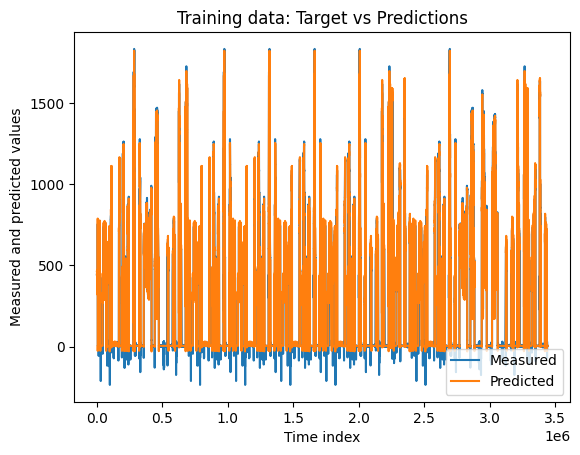

In [82]:
# Create a Lasso model with alpha=0.1 (controls the strength of regularization) -> MIN[(sum of squared residuals) + alpha * (sum of absolute values of coefficients)]
lasso = Lasso(alpha=0.1, fit_intercept=True)

# Train the model on the training data
lasso.fit(X_train, y_train)

# Evaluate
print("Coefficients = ", list(lasso.coef_) + [lasso.intercept_])
y_train_pred = lasso.predict(X_train)
print("rmse = ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("mae = ", mean_absolute_error(y_train, y_train_pred))

# Plot the training target against the predicted values
plt.plot(X_train.index, y_train, X_train.index, y_train_pred)
plt.xlabel('Time index')
plt.ylabel('Measured and predicted values')
plt.title('Training data: Target vs Predictions')
plt.legend(['Measured', 'Predicted'])
plt.show()

### Train and evaluate model

To train model withouth heatCoilEnable flag, but temperature instead go to Compaison of statis and dynamic model first

In [425]:
energy_train['system.quattId'].value_counts()

CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c        267269
CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp1    267162
CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp2    267162
CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp1    266393
CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp2    266393
CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6        253061
Name: system.quattId, dtype: int64

Coefficients =  [1.1240096401010435, -0.04858859969715763, 150.06430841218332, 5.150232354845286]
rmse =  19.146657481188008
mae =  7.6225074031447635


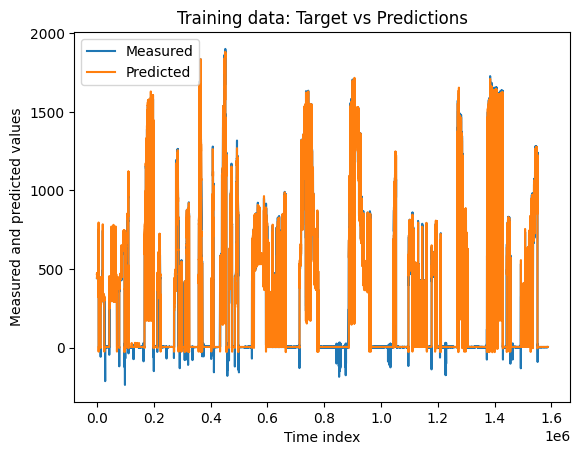

In [426]:
# Create a Linear model
regression_columns = ['qc.hp1PowerInput','hp1.getFanSpeed','hp1.bottomPlateHeaterEnable']
# regression_columns = ['qc.hp1PowerInput','hp1.getFanSpeed', 'bottomPlateHeaterEnableCalc1', 'bottomPlateHeaterEnableCalc2']

linreg = train_model(X_train[regression_columns], y_train)

rmse =  15.623846975405248
mae =  6.443848554993267
r2 =  0.9979072675917146
mean of errors =  -0.6390257337205068


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


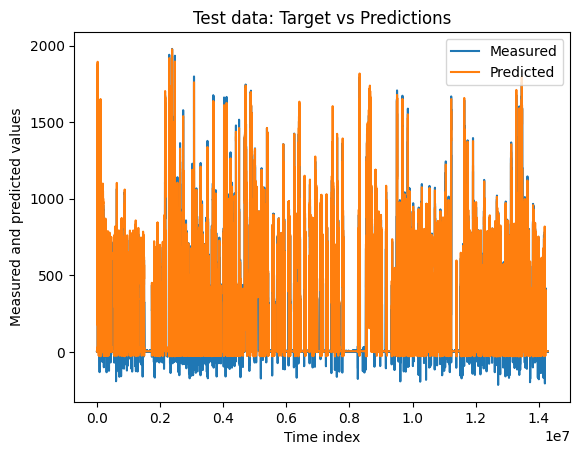

In [427]:
evaluate_model(linreg, X_test=X_test[regression_columns], y_test=y_test)

#### Calculating model parameters for each heatpump using normalized input values, to see the variance for different parameters

In [74]:
regression_columns = ['qc.hp1PowerInput','hp1.getFanSpeed','hp1.bottomPlateHeaterEnable']

# add regression columns to energy_df

# create scalar based on train data set
scaler = preprocessing.StandardScaler().fit(X_train[regression_columns])

# scale both data sets
X_train_scaled = scaler.transform(X_train[regression_columns])
X_test_scaled = scaler.transform(X_test[regression_columns])

# create a linear model for the scaled data
linreg = train_model(X_train_scaled, y_train)
# evaluate_model(linreg, X_test=X_test_scaled, y_test=y_test)
df_linreg = pd.DataFrame([linreg.coef_[0].tolist() + linreg.intercept_.tolist()], columns=regression_columns + ['intercept'])
df_linreg['source'] = 'train_data_set'

# add coefficient columns to energy data set to split based on hp id
energy_train['hp1.getFanSpeed'] = X_train['hp1.getFanSpeed']
energy_train['hp1.bottomPlateHeaterEnable'] = X_train['hp1.bottomPlateHeaterEnable']
energy_train['qc.hp1PowerInput'] = X_train['qc.hp1PowerInput']
energy_train['y_measured'] = y_train

def train_model(X_train, y_train):
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    return linreg

energy_train['y_predictedHpSpecific'] = 0

for key, grp in energy_train.groupby('system.quattId'):
    X_train_temp = grp[regression_columns]
    X_train_temp_scaled = scaler.transform(X_train_temp)
    y_train_temp = grp['y_measured']
    linreg_temp = train_model(X_train_temp_scaled, y_train_temp)

    df_linreg = df_linreg.append({'source': key,
                      'qc.hp1PowerInput': linreg_temp.coef_[0], 
                      'hp1.getFanSpeed': linreg_temp.coef_[1], 
                      'hp1.bottomPlateHeaterEnable': linreg_temp.coef_[2], 
                      'hp1.compressorCrankCaseHeaterEnable': 0, 
                      'intercept': linreg_temp.intercept_}, ignore_index=True)

    energy_df.loc[energy_df['system.quattId']==key, 'y_predictedHpSpecific'] = linreg_temp.predict(scaler.transform(energy_df.loc[energy_df['system.quattId']==key, regression_columns]))
    
energy_df['predictedPowerHpSpecific'] = energy_df['y_predictedHpSpecific'] + energy_df['hp1.circulatingPumpDutyCycle'] - energy_df['offset'] # W
energy_df['predictedEnergyHpSpecific[kWh]'] = (energy_df['predictedPowerHpSpecific'] * energy_df['timeDelta[S]']) / 3600000
energy_df['totalPredictedEnergyHpSpecific[kWh]'] = energy_df.groupby('system.quattId', sort='time.ts')['predictedEnergyHpSpecific[kWh]'].cumsum()

df_linreg


/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_61179/3456837558.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_linreg = df_linreg.append({'source': key,
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_61179/3456837558.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_linreg = df_linreg.append({'source': key,
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_61179/3456837558.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_linreg = df_linreg.append({'source': key,
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_61179/3456837558.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

,qc.hp1PowerInput,hp1.getFanSpeed,hp1.bottomPlateHeaterEnable,intercept,source,hp1.compressorCrankCaseHeaterEnable
0,379.547324,-11.079636,35.505805,259.179026,train_data_set,NaN
1,382.432812,-2.723775,32.489864,266.109912,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,0.0
2,381.322891,-9.657521,36.785221,261.800714,CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp1,0.0
3,377.662916,-8.825643,36.273830,259.945530,CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp2,0.0
4,370.800979,-15.177697,39.732189,251.662388,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,0.0
5,379.142838,-20.155128,34.215955,251.836130,CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp1,0.0
6,386.915173,-11.294397,34.150377,263.593854,CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp2,0.0


In [95]:
df_linreg.describe()

,qc.hp1PowerInput,hp1.getFanSpeed,hp1.bottomPlateHeaterEnable,intercept,hp1.compressorCrankCaseHeaterEnable
count,7.000000,7.000000,7.000000,7.000000,6.0
mean,379.689276,-11.273400,35.593320,259.161079,0.0
std,4.930111,5.413952,2.332105,5.558843,0.0
min,370.800979,-20.155128,32.489864,251.662388,0.0
25%,378.402877,-13.236047,34.183166,255.507578,0.0
50%,379.547324,-11.079636,35.505805,259.945530,0.0
75%,381.877851,-9.241582,36.529525,262.697284,0.0
max,386.915173,-2.723775,39.732189,266.109912,0.0


### use estimated model to calculate energy usage

In [428]:
# for each row in energy_test and energy_train set -> get measured power and predicted y
# energy_train['y_predicted'] = linreg.predict(X_train[regression_columns])
# energy_train['y_measured'] = y_train
# energy_train['qc.hp1PowerInput'] = X_train['qc.hp1PowerInput']
# energy_train['hp1.getFanSpeed'] = X_train['hp1.getFanSpeed']
# energy_train['hp1.bottomPlateHeaterEnable'] = X_train['hp1.bottomPlateHeaterEnable']
energy_test['y_predicted'] = linreg.predict(X_test[regression_columns])
energy_test['y_measured'] = y_test
energy_test['qc.hp1PowerInput'] = X_test['qc.hp1PowerInput']
energy_test['hp1.getFanSpeed'] = X_test['hp1.getFanSpeed']
energy_test['hp1.bottomPlateHeaterEnable'] = X_test['hp1.bottomPlateHeaterEnable']

# concatenate in one frame
# energy_df = pd.concat([energy_train, energy_test], ignore_index=True)
energy_df = energy_test
energy_df = energy_df.sort_values(by=['system.quattId', 'time.ts'])
energy_df = energy_df.reset_index(drop=True)

# combine 'system' and 'qc' values to one column
energy_df['system.externalElectricityMeterEnergy'] = energy_df['system.externalElectricityMeterEnergy'].combine_first(energy_df['qc.externalElectricityMeterEnergy'])
energy_df['system.externalElectricityMeterPower'] = energy_df['system.externalElectricityMeterPower'].combine_first(energy_df['qc.externalElectricityMeterPower'])
energy_df.drop(['qc.externalElectricityMeterEnergy', 'qc.externalElectricityMeterPower'], axis=1, inplace=True)


# energy_df["externalElectricityMeterDiff"] = energy_df.groupby('system.quattId', sort='time.ts')["system.externalElectricityMeterEnergy"].diff()
energy_df['timeDelta[S]'] = energy_df.groupby('system.quattId', sort='time.ts')['time.ts'].diff()/1000

# y train = measured Power + offset - pumpdutycycle  -->  measured Power = y train + pumpdutycycle - offset
def set_column_offset(row):
    if row['system.quattId'] == 'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6':
        return -11.74
    elif row['system.quattId'] == 'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c':
        return -10.07
    else:
        return 0
    
energy_df['offset'] = energy_df.apply(lambda row: set_column_offset(row), axis=1)
energy_df['measuredPower'] = energy_df['y_measured'] + energy_df['hp1.circulatingPumpDutyCycle'] - energy_df['offset'] # W
energy_df['predictedPower'] = energy_df['y_predicted'] + energy_df['hp1.circulatingPumpDutyCycle'] - energy_df['offset'] # W

energy_df['predictedEnergy[kWh]'] = (energy_df['predictedPower'] * energy_df['timeDelta[S]']) / 3600000
energy_df['measuredEnergy[kWh]'] = (energy_df['measuredPower'] * energy_df['timeDelta[S]']) / 3600000

energy_df['totalPredictedEnergy[kWh]'] = energy_df.groupby('system.quattId', sort='time.ts')['predictedEnergy[kWh]'].cumsum()
energy_df['totalMeasuredEnergy[kWh]'] = energy_df.groupby('system.quattId', sort='time.ts')['measuredEnergy[kWh]'].cumsum()

energy_df['totalMeterEnergy[kWh]'] = energy_df.groupby('system.quattId', sort='time.ts')['system.externalElectricityMeterEnergy'].apply(lambda x: x - x.iloc[0])

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_61179/487532236.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  energy_df['totalMeterEnergy[kWh]'] = energy_df.groupby('system.quattId', sort='time.ts')['system.externalElectricityMeterEnergy'].apply(lambda x: x - x.iloc[0])


Predicted errors:  [-0.028595339819227465, 0.0066726773358225175, 0.025443868750179587, 0.02929652879777813, 0.030238729826199812, -0.015231134303968325]
Masured errors:  [0.0053563457661476915, 0.012682489614331102, 0.013467936269546933, -0.00017760669799699982, -0.00016444692532086716, 0.00032058916074992013]


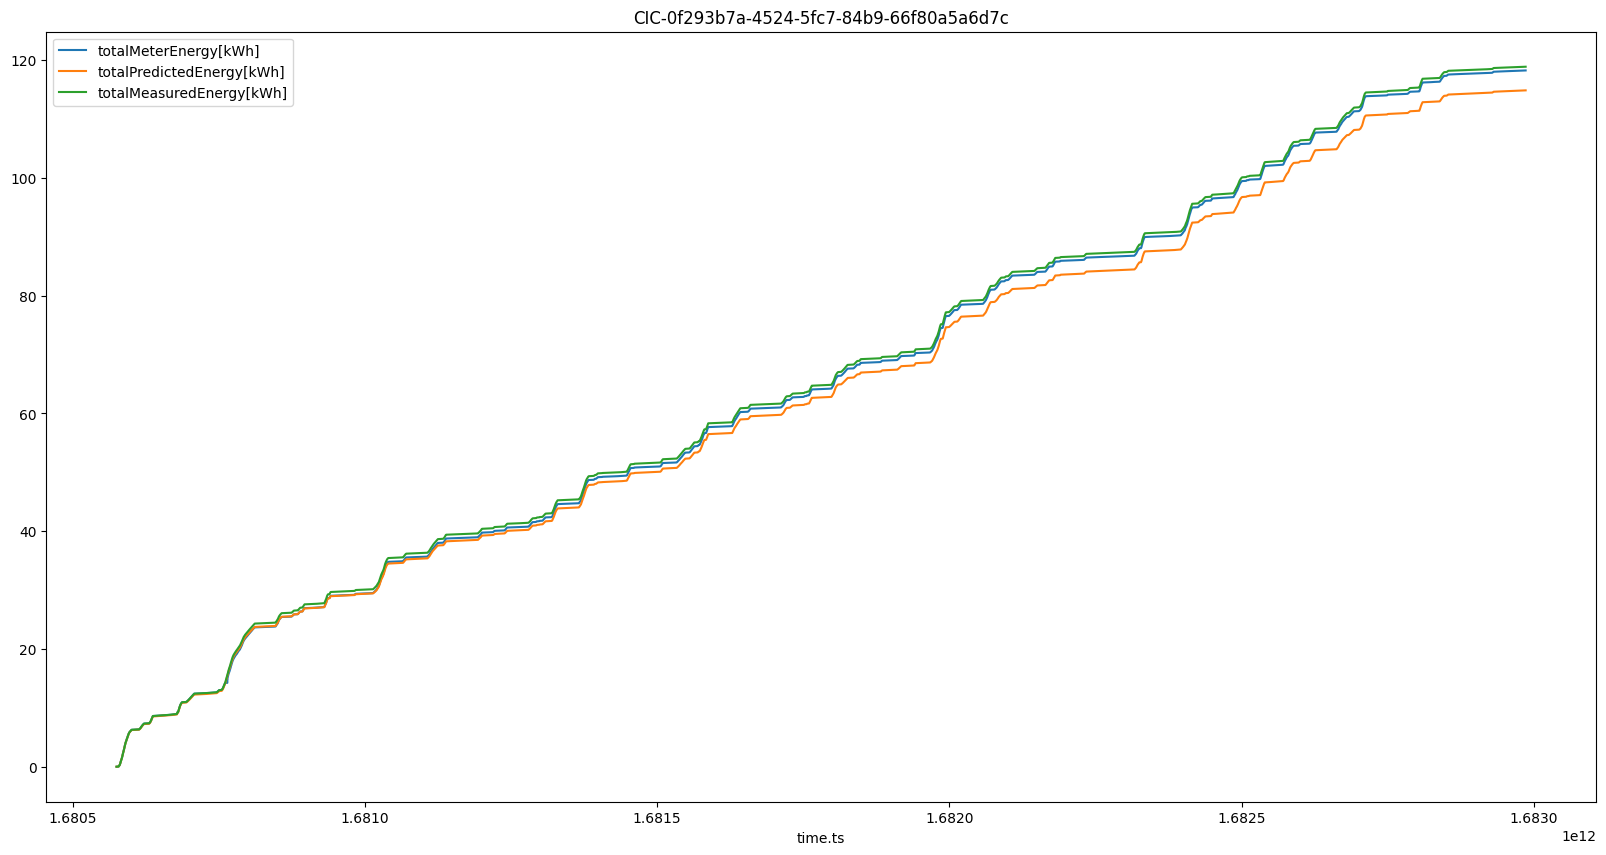

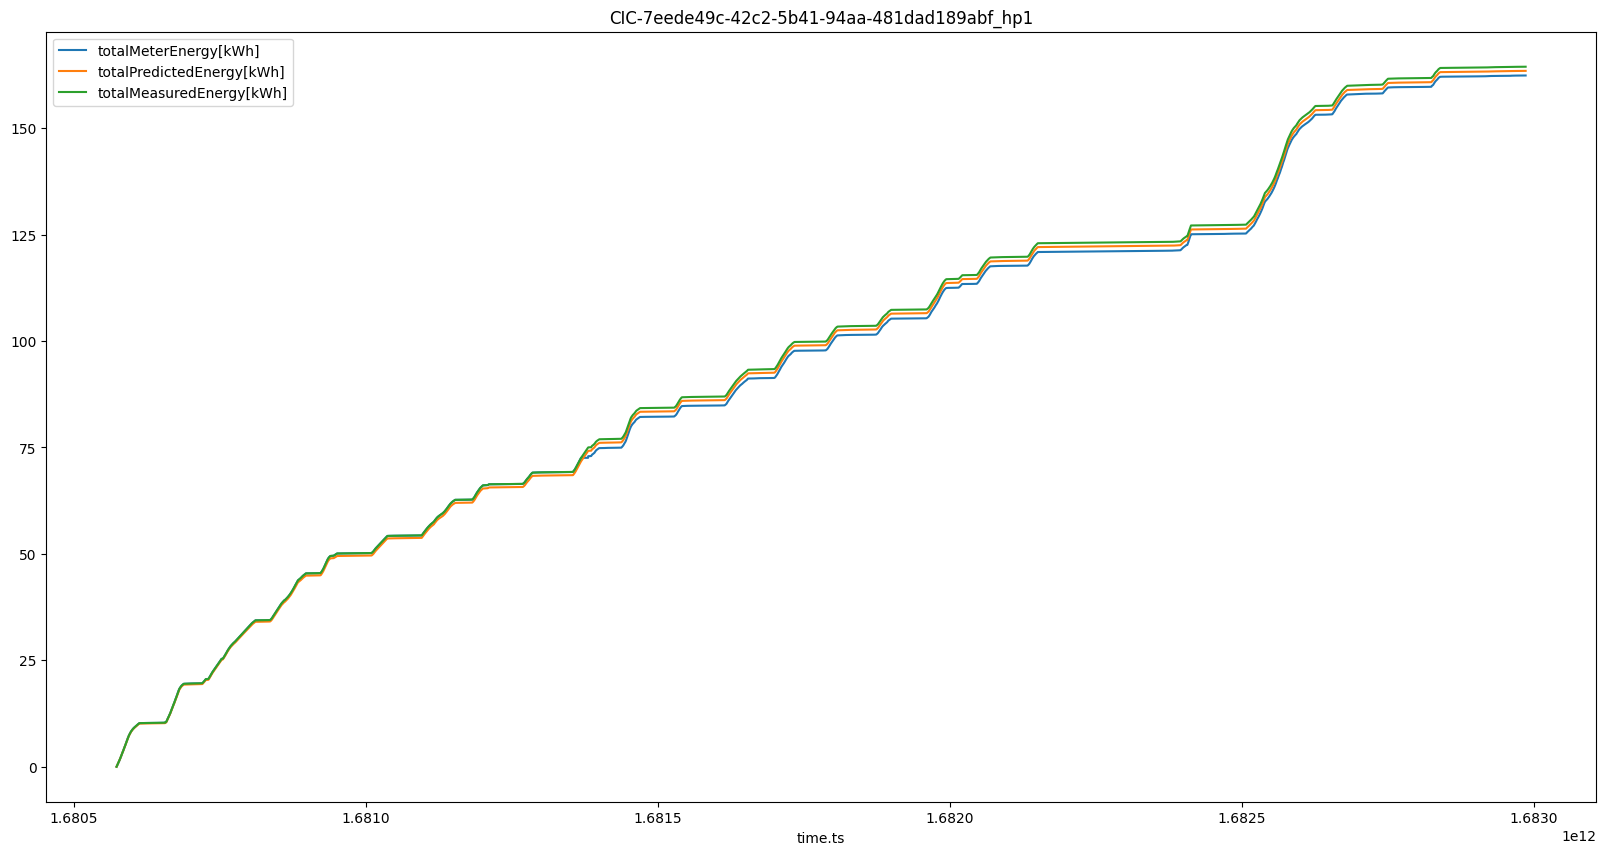

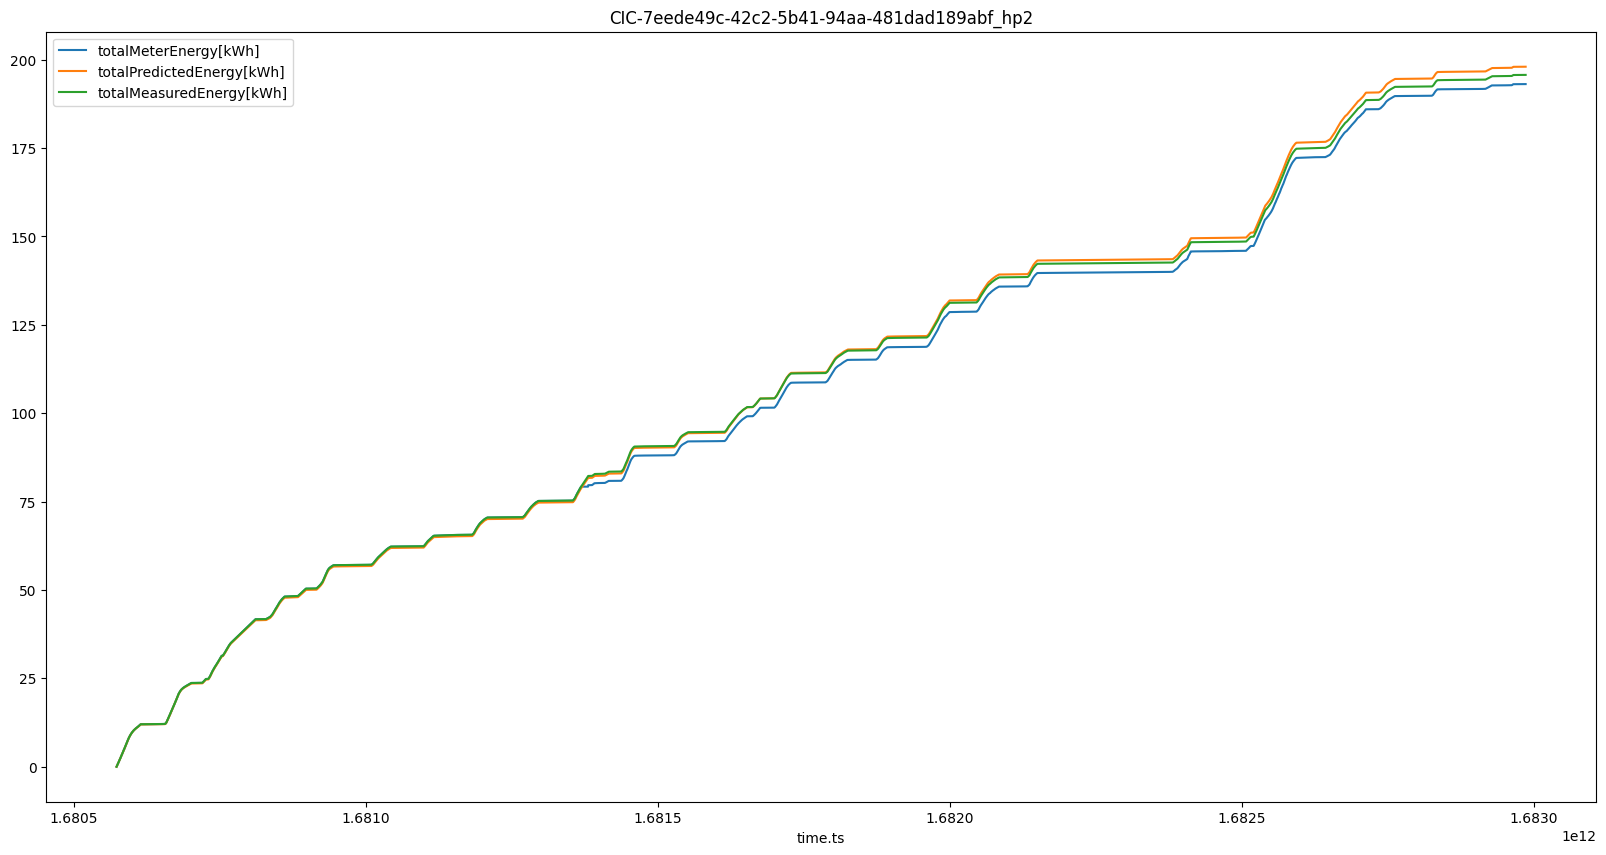

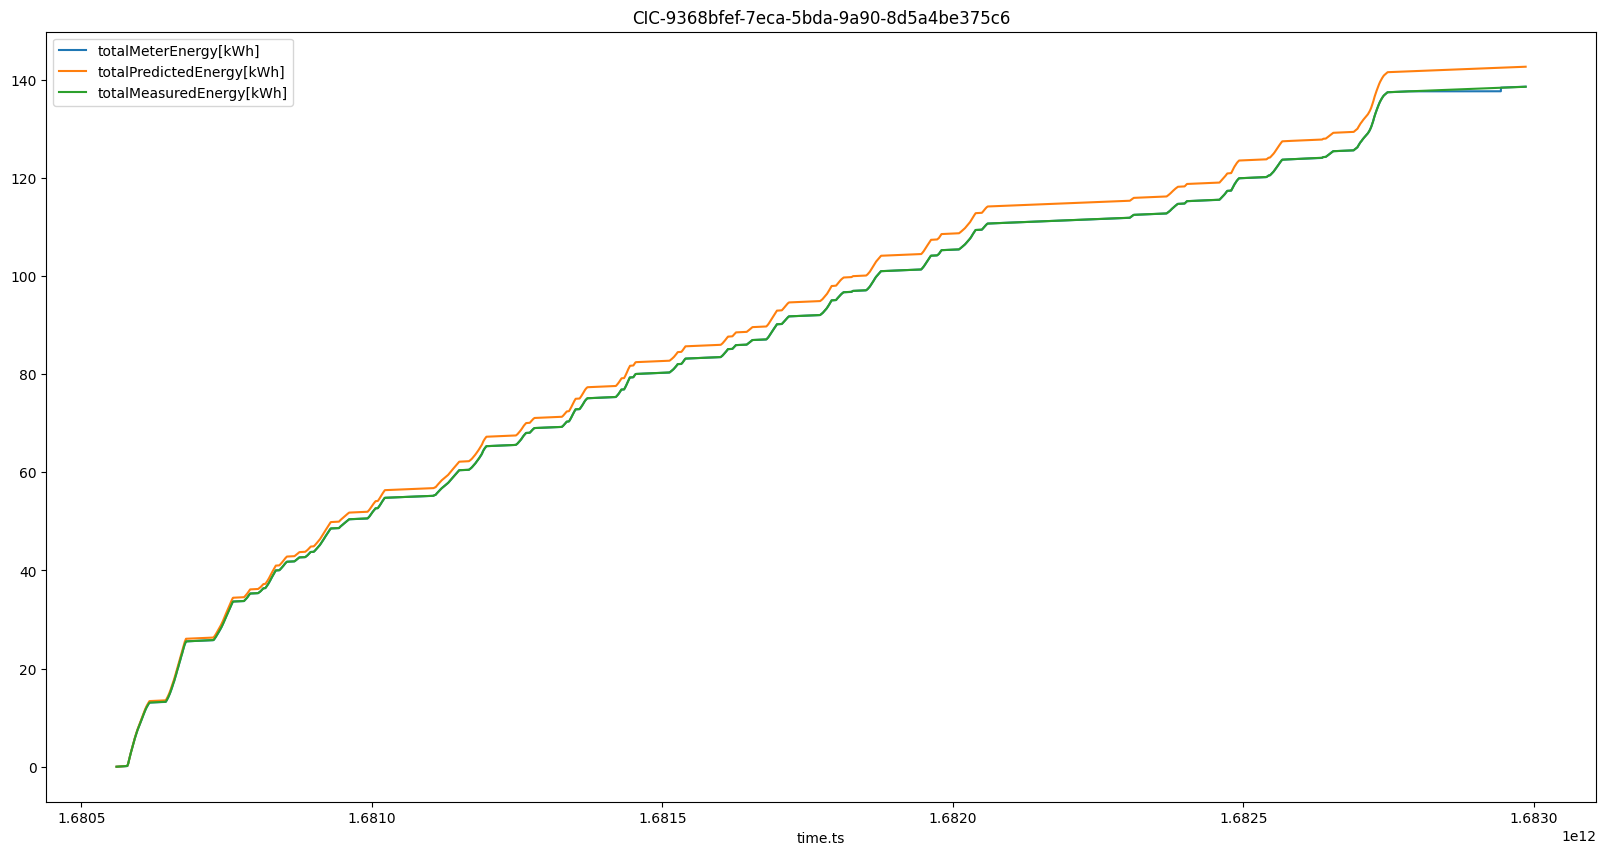

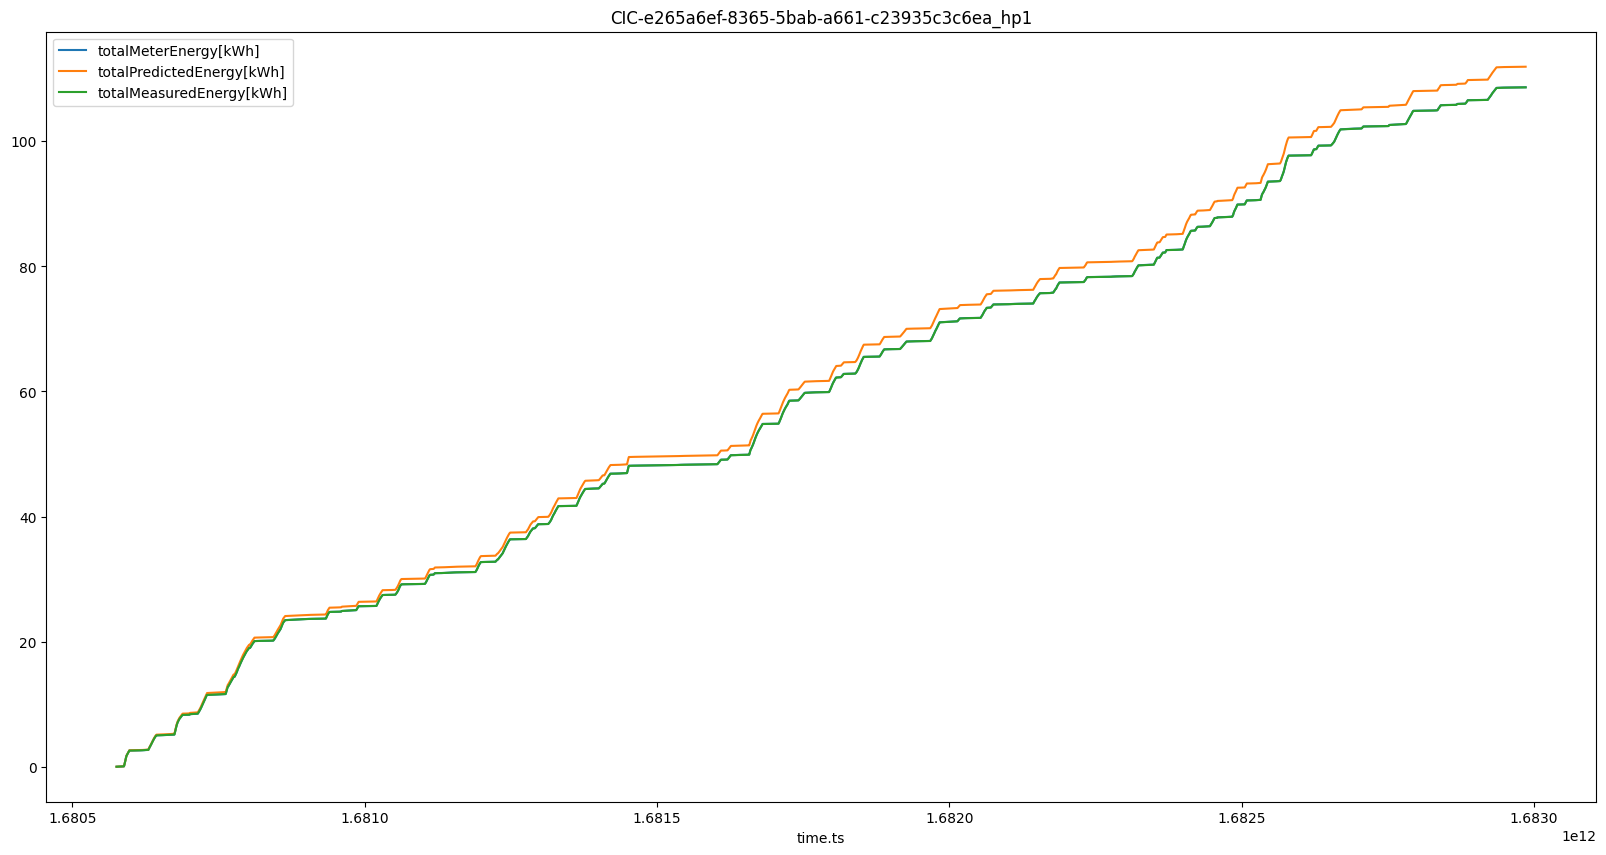

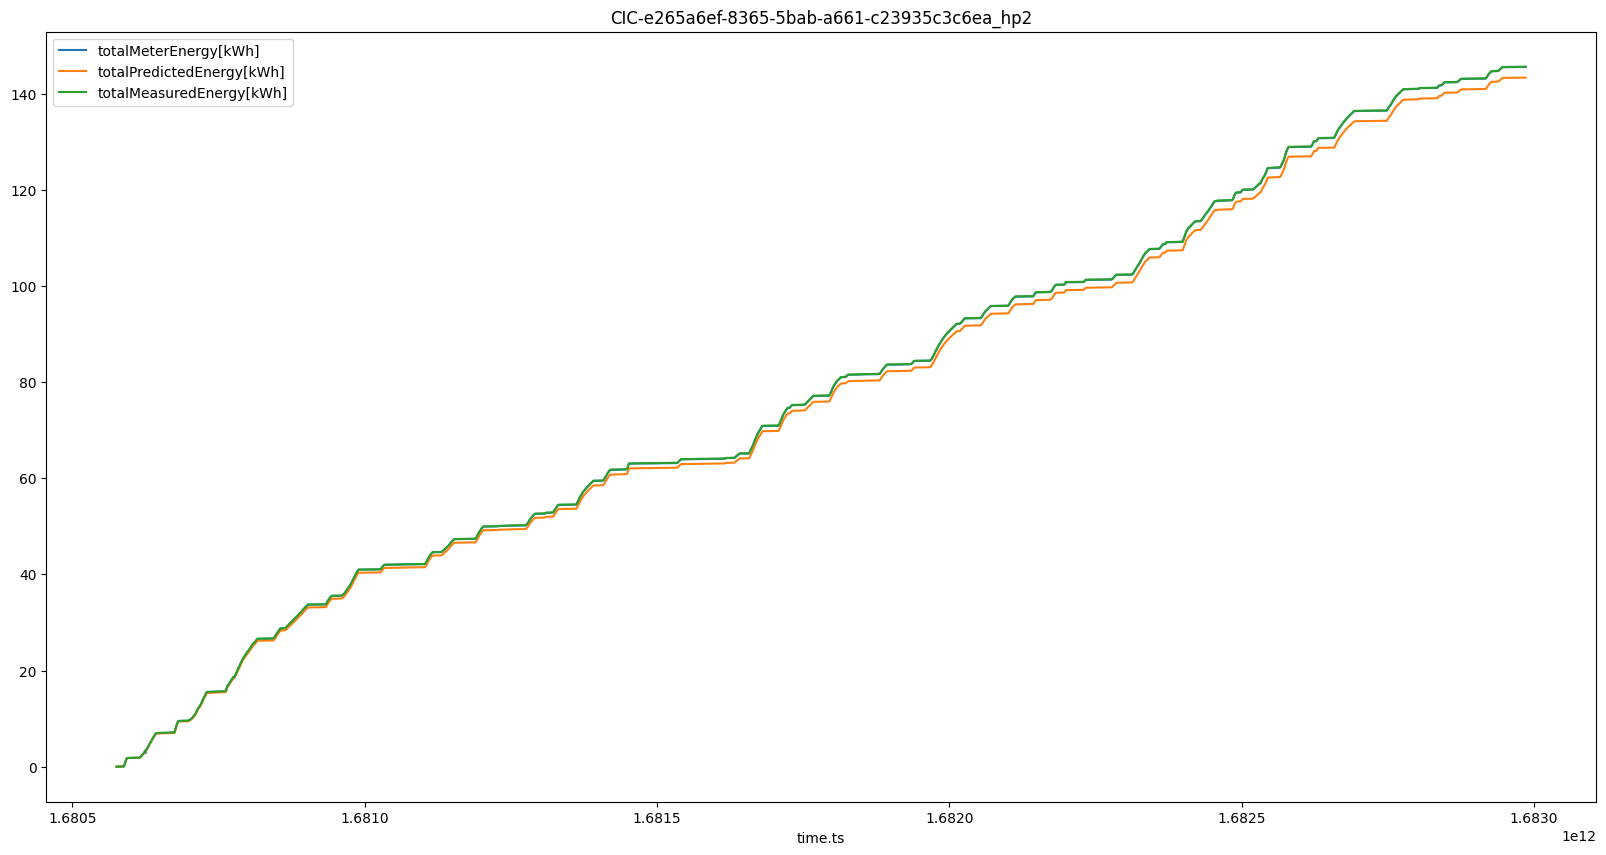

In [429]:
predictedErrors = []
measuredErrors = []
cicErrors = []

for key, grp in energy_df.groupby('system.quattId'):
    grp[['time.ts','totalMeterEnergy[kWh]','totalPredictedEnergy[kWh]','totalMeasuredEnergy[kWh]']].plot(x='time.ts', figsize=(20,10), 
                                                                                                         title=f'{key}')
    predictedErrors.append((grp['totalPredictedEnergy[kWh]'].iloc[-1] - grp['totalMeterEnergy[kWh]'].iloc[-1])/grp['totalMeterEnergy[kWh]'].iloc[-1])
    measuredErrors.append((grp['totalMeasuredEnergy[kWh]'].iloc[-1] - grp['totalMeterEnergy[kWh]'].iloc[-1])/grp['totalMeterEnergy[kWh]'].iloc[-1])
    cicErrors.append(key)

print("Predicted errors: ", predictedErrors)
print("Masured errors: ", measuredErrors)

In [432]:
print(np.mean(predictedErrors))
print(np.std(predictedErrors))

0.007970888431130708
0.02285115970134678


#### Extra cells to visualize where different errors are coming from

### Estimating offset, electrical consumption of electricity meter itself

rated power bottem heater = 140W bij onder de 4 graden  
rated power andere heater = 30W  

- cic id =  CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6  
    Coefficients =  [1.0476004037871844, -0.01893493545094307, 169.76709082687836, 0.0, 16.842253853977695]  
    rmse =  7.9856129473862945  
    mae =  3.9406276747781117  
- cic id =  CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c  
    Coefficients =  [1.1242435956052503, -0.036374866620681054, 152.35218089351477, 0.0, 15.177239884722951]  
    rmse =  10.785040785694678  
    mae =  3.5985874111473573  
- cic id =  CIC-7eede49c-42c2-5b41-94aa-481dad189abf  
    Coefficients =  [1.1213285599080334, -0.035666427179100485, 160.66726903177891, 0.0, 4.891744820873043]  
    rmse =  16.298928047350987  
    mae =  5.537046840242883  
- cic id =  CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea  
    Coefficients =  [1.118230234270296, -0.072224987428126, 144.06290304400045, 0.0, 5.220130176329377]  
    rmse =  17.288476812023205  
    mae =  4.145755511458696  

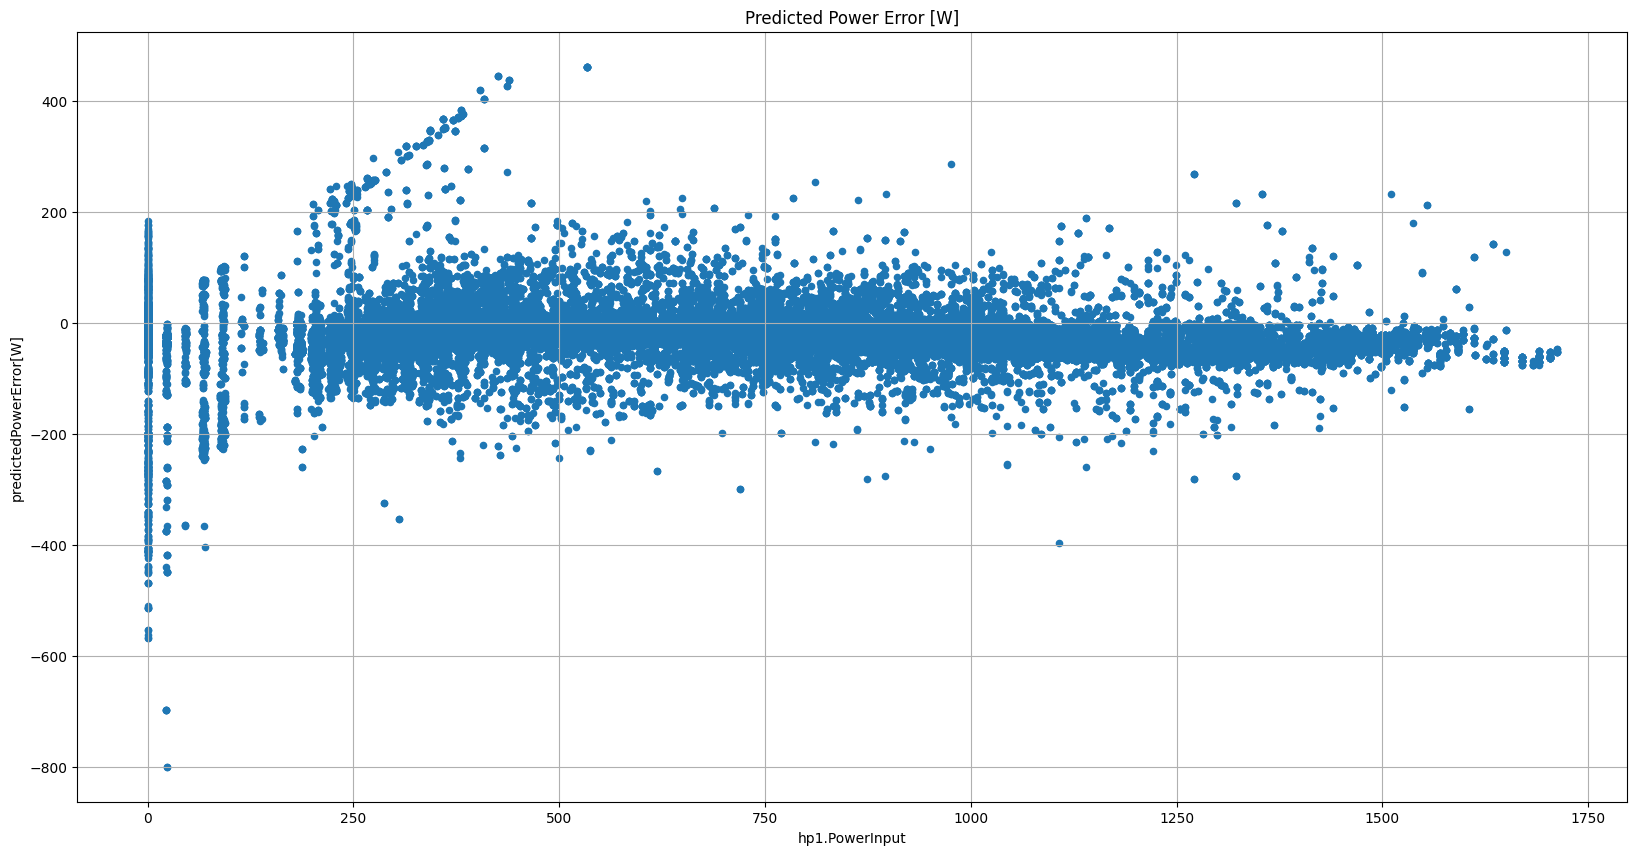

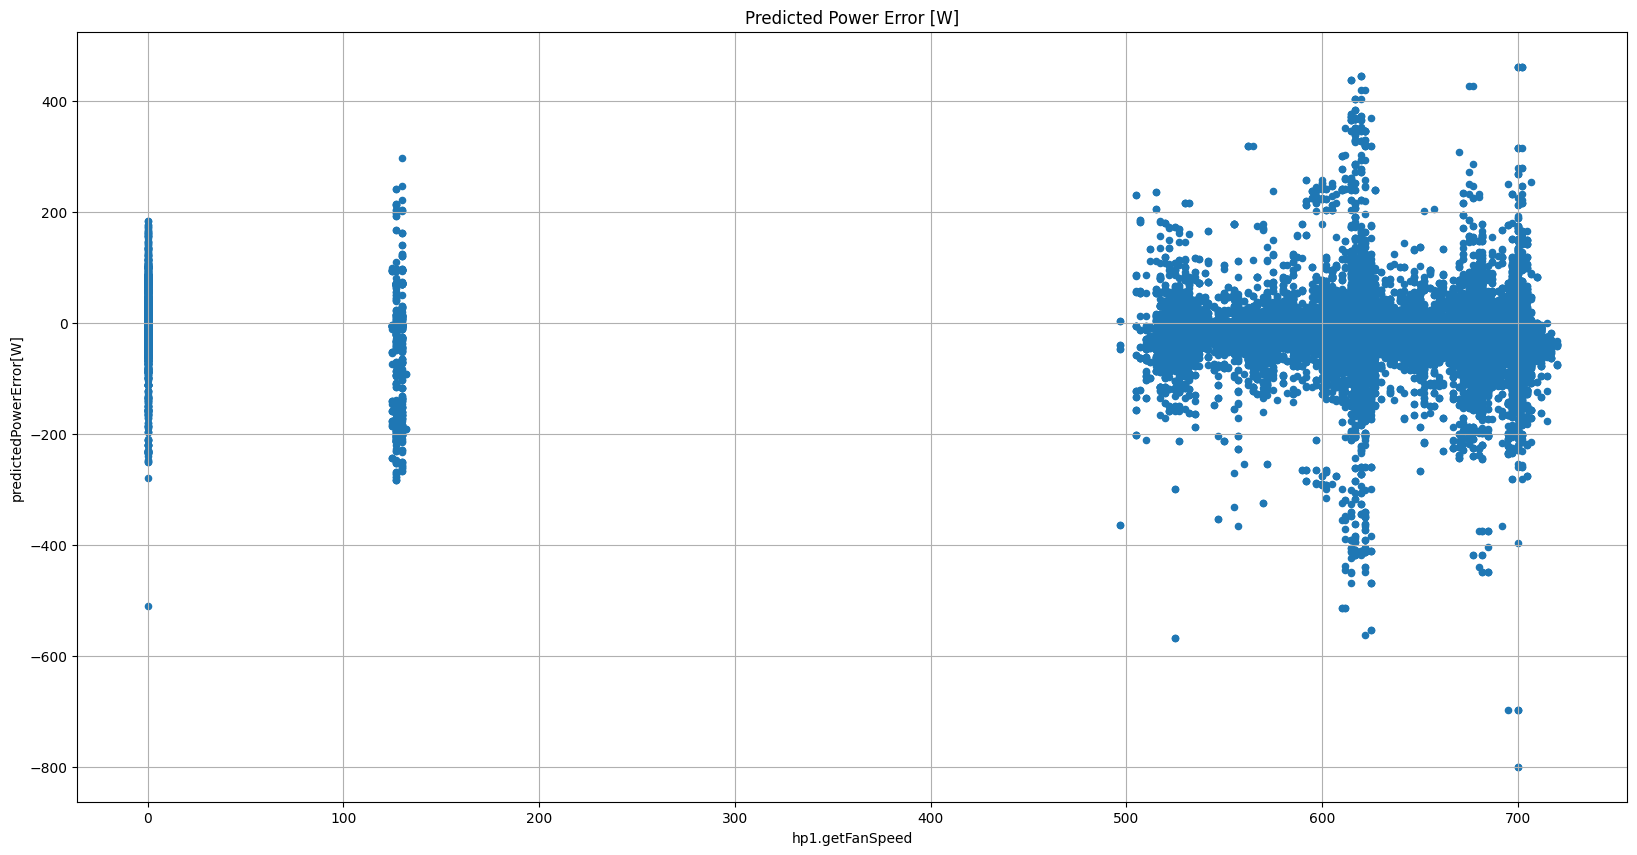

Mean absolute error with bottomPlateHeateEnable:  16.075977674866373
Mean absolute error without bottomPlateHeateEnable:  7.179508899641155


In [8]:
# Research where differences in measured and predicted energy come from
# add a column with the relative difference in measured and predicted power
# add a column with the absolute difference in measured and predicted power
# add the relevant features to the frame
# search for correlations between the features and the differences

energy_df['predictedPowerError[%]'] = (energy_df['predictedPower'] - energy_df['measuredPower']) / energy_df['measuredPower']
energy_df['predictedPowerError[W]'] = energy_df['predictedPower'] - energy_df['measuredPower']



# energy_df[(energy_df['system.quattId']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c') & 
#           (energy_df['hp1.PowerInput']==0)]['predictedPowerError[%]'].plot(figsize=(20,10), title='Predicted Power Error [%]')
# plt.show()
energy_df[energy_df['system.quattId']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c'].plot.scatter(y='predictedPowerError[W]', x='qc.hp1PowerInput', figsize=(20,10), title='Predicted Power Error [W]')
plt.grid()
plt.show()
energy_df[energy_df['system.quattId']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c'].plot.scatter(y='predictedPowerError[W]', x='qc.hp1PowerInput', figsize=(20,10), title='Predicted Power Error [W]')
plt.grid()
plt.show()
print('Mean absolute error with bottomPlateHeateEnable: ', energy_df[(energy_df['system.quattId']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c') & 
                                                                     (energy_df['hp1.bottomPlateHeaterEnable']==1)]['predictedPowerError[W]'].abs().mean())
print('Mean absolute error without bottomPlateHeateEnable: ', energy_df[(energy_df['system.quattId']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c') & 
                                                                        (energy_df['hp1.bottomPlateHeaterEnable']==0)]['predictedPowerError[W]'].abs().mean())

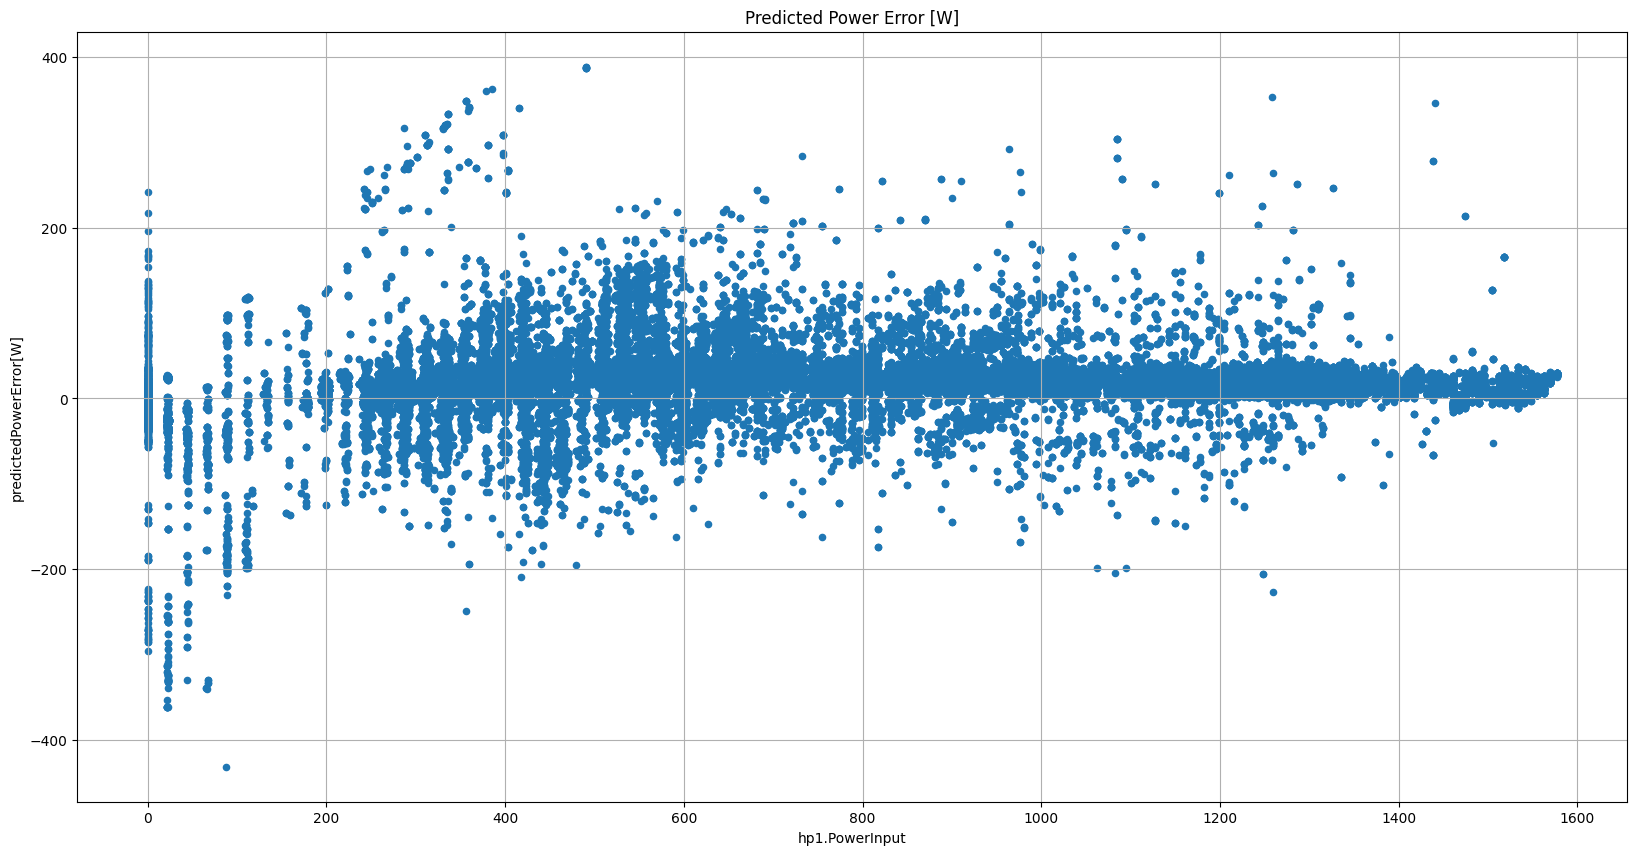

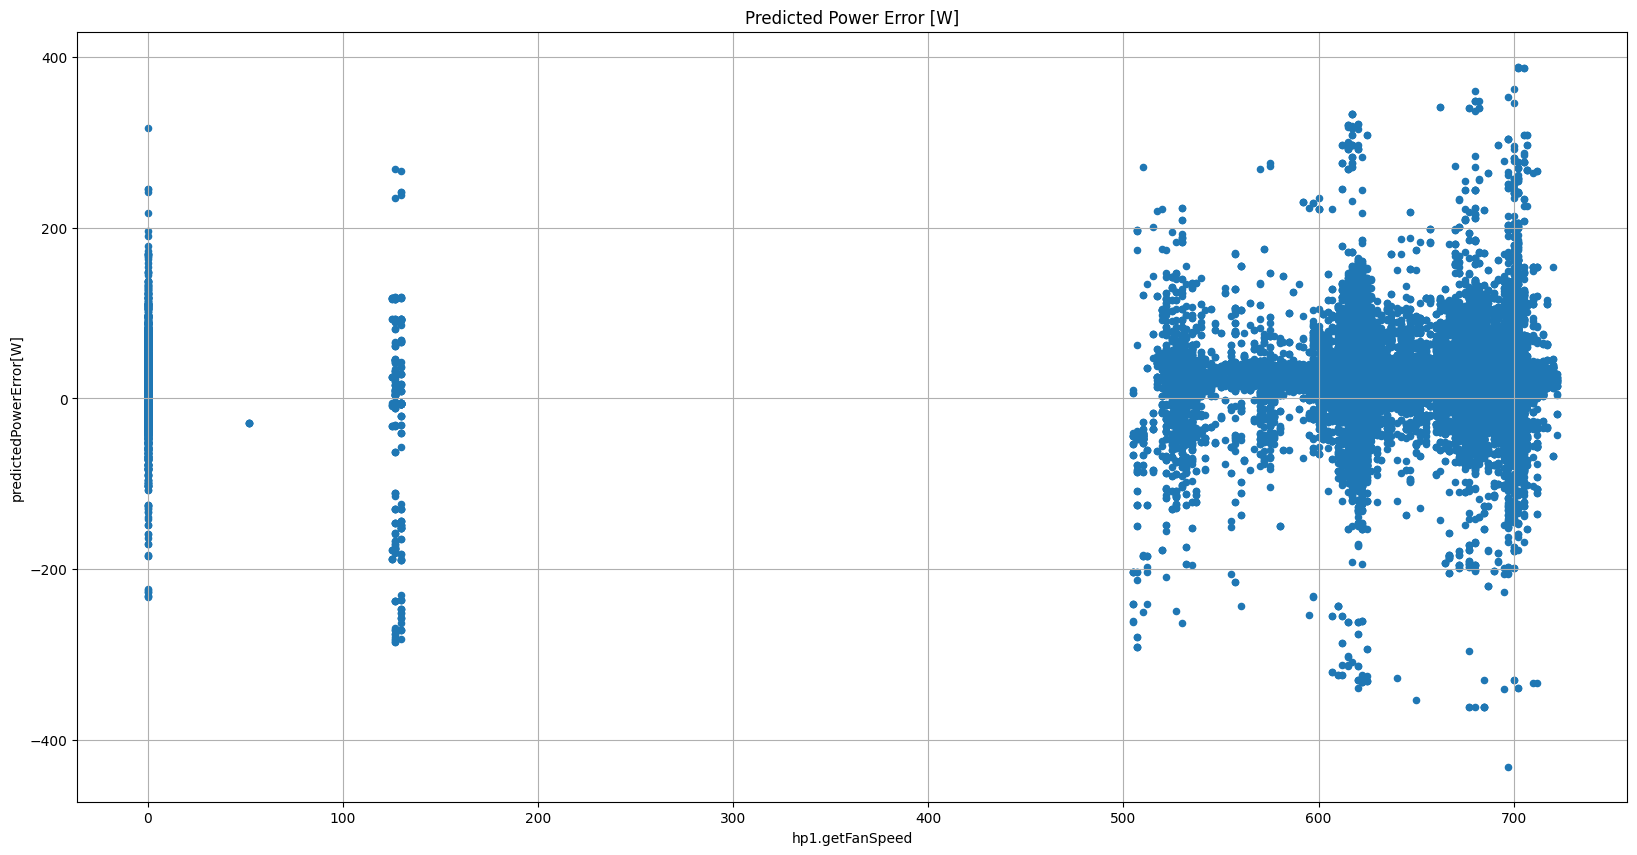

Mean absolute error with bottomPlateHeateEnable:  22.203337740094522
Mean absolute error without bottomPlateHeateEnable:  7.628783204547971


In [9]:

energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6'].plot.scatter(y='predictedPowerError[W]', x='qc.hp1PowerInput', figsize=(20,10), title='Predicted Power Error [W]')
plt.grid()
plt.show()
energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6'].plot.scatter(y='predictedPowerError[W]', x='qc.hp1PowerInput', figsize=(20,10), title='Predicted Power Error [W]')
plt.grid()
plt.show()
print('Mean absolute error with bottomPlateHeateEnable: ', energy_df[(energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6') & 
                                                                     (energy_df['hp1.bottomPlateHeaterEnable']==1)]['predictedPowerError[W]'].abs().mean())
print('Mean absolute error without bottomPlateHeateEnable: ', energy_df[(energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6') & 
                                                                        (energy_df['hp1.bottomPlateHeaterEnable']==0)]['predictedPowerError[W]'].abs().mean())


In [101]:
energy_df[(energy_df['system.quattId']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c') &
          (energy_df['qc.hp1PowerInput']>0)]['predictedPowerError[%]'].describe()


count    739931.000000
mean         -0.039713
std           0.114621
min          -0.968572
25%          -0.059800
50%          -0.036955
75%          -0.020852
max          10.763046
Name: predictedPowerError[%], dtype: float64

In [10]:
# Create linear model for each heatpump seperately
regression_columns = ['qc.hp1PowerInput','hp1.getFanSpeed','hp1.bottomPlateHeaterEnable']
# regression_columns = ['qc.hp1PowerInput','hp1.getFanSpeed', 'bottomPlateHeaterEnableCalc1', 'bottomPlateHeaterEnableCalc2']

def train_model(X_train, y_train):
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    return linreg

energy_df['y_predictedHpSpecific'] = 0

for key, grp in energy_df.groupby('system.quattId'):
    X_train_temp = grp[regression_columns]
    y_train_temp = grp['y_measured']
    linreg_temp = train_model(X_train_temp, y_train_temp)

    df_linreg = df_linreg.append({'source': key,
                      'qc.hp1PowerInput': linreg_temp.coef_[0], 
                      'hp1.getFanSpeed': linreg_temp.coef_[1], 
                      'hp1.bottomPlateHeaterEnable': linreg_temp.coef_[2], 
                      'hp1.compressorCrankCaseHeaterEnable': 0, 
                      'intercept': linreg_temp.intercept_}, ignore_index=True)

    energy_df.loc[energy_df['system.quattId']==key, 'y_predictedHpSpecific'] = linreg_temp.predict(energy_df.loc[energy_df['system.quattId']==key, regression_columns])
    
energy_df['predictedPowerHpSpecific'] = energy_df['y_predictedHpSpecific'] + energy_df['hp1.circulatingPumpDutyCycle'] - energy_df['offset'] # W
energy_df['predictedEnergyHpSpecific[kWh]'] = (energy_df['predictedPowerHpSpecific'] * energy_df['timeDelta[S]']) / 3600000
energy_df['totalPredictedEnergyHpSpecific[kWh]'] = energy_df.groupby('system.quattId', sort='time.ts')['predictedEnergyHpSpecific[kWh]'].cumsum()

# for key, grp in energy_df.groupby('system.quattId'):
#     grp[['time.ts','totalMeterEnergy[kWh]','totalPredictedEnergy[kWh]','totalMeasuredEnergy[kWh]', 'totalPredictedEnergyHpSpecific[kWh]']].plot(x='time.ts', figsize=(20,10), 
#                                                                                                          title=f'{key}')


/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_42798/4124100836.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_linreg = df_linreg.append({'source': key,
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_42798/4124100836.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_linreg = df_linreg.append({'source': key,
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_42798/4124100836.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_linreg = df_linreg.append({'source': key,
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_42798/4124100836.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

In [11]:
df_linreg

,qc.hp1PowerInput,hp1.getFanSpeed,hp1.bottomPlateHeaterEnable,hp1.compressorCrankcaseHeaterEnable,intercept,source,hp1.compressorCrankCaseHeaterEnable
0,1.109449,-0.035745,155.012555,0.0,5.072131,train_data_set,NaN
1,1.118220,-0.004676,139.939493,NaN,4.263404,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,0.0
2,1.119624,-0.038344,158.952677,NaN,5.131006,CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp1,0.0
3,1.096371,-0.034580,165.657635,NaN,5.117377,CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp2,0.0
4,1.089138,-0.053018,167.665679,NaN,5.590860,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,0.0
5,1.104182,-0.062208,150.298259,NaN,5.258581,CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp1,0.0
6,1.127465,-0.034194,149.550127,NaN,5.033535,CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp2,0.0


<Axes: >

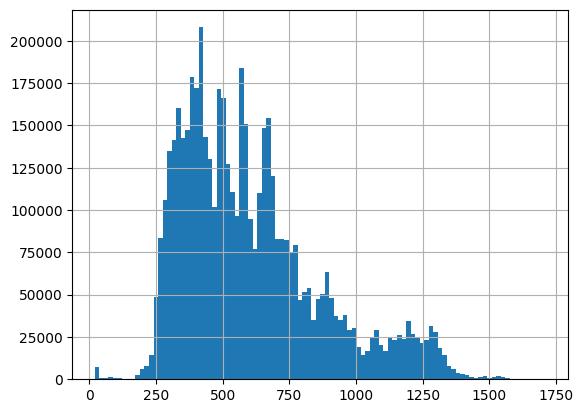

In [17]:
energy_df[energy_df['hp1.PowerInput']>0]['hp1.PowerInput'].hist(bins=100)

<Axes: >

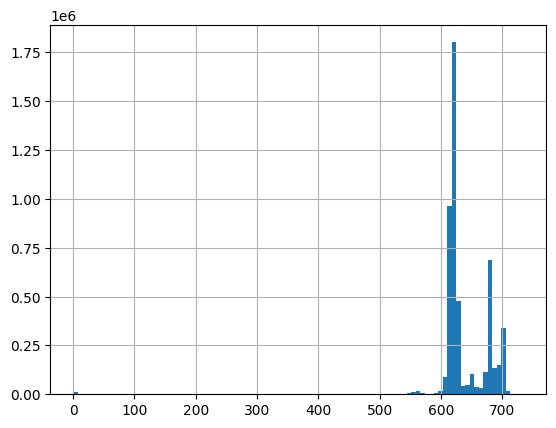

In [18]:
energy_df[energy_df['hp1.PowerInput']>0]['hp1.getFanSpeed'].hist(bins=100)

In [15]:
df_test = energy_df.copy()

df_test['hp1.PowerInputRounded'] = df_test['hp1.PowerInput'].round(-1)
powers = df_test[df_test['hp1.PowerInputRounded']>0]['hp1.PowerInputRounded'].sort_values().unique()
power_df = pd.DataFrame(powers, columns=['hp1.PowerInputRounded'])

power_df['averageFanSpeed-CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c'] = power_df['hp1.PowerInputRounded'].apply(lambda x: df_test[(df_test['hp1.PowerInputRounded']==x) & 
                                                                                                                                 (df_test['system.quattId']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')]['hp1.getFanSpeed'].mean())
power_df['averageFanSpeed-CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6'] = power_df['hp1.PowerInputRounded'].apply(lambda x: df_test[(df_test['hp1.PowerInputRounded']==x) &
                                                                                                                                 (df_test['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6')]['hp1.getFanSpeed'].mean())
power_df['averageFanSpeed-CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp1'] = power_df['hp1.PowerInputRounded'].apply(lambda x: df_test[(df_test['hp1.PowerInputRounded']==x) & 
                                                                                                                                 (df_test['system.quattId']=='CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp1')]['hp1.getFanSpeed'].mean())

In [18]:
power_df['averageFanSpeed-CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp2'] = power_df['hp1.PowerInputRounded'].apply(lambda x: df_test[(df_test['hp1.PowerInputRounded']==x) & 
                                                                                                                                 (df_test['system.quattId']=='CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp2')]['hp1.getFanSpeed'].mean())

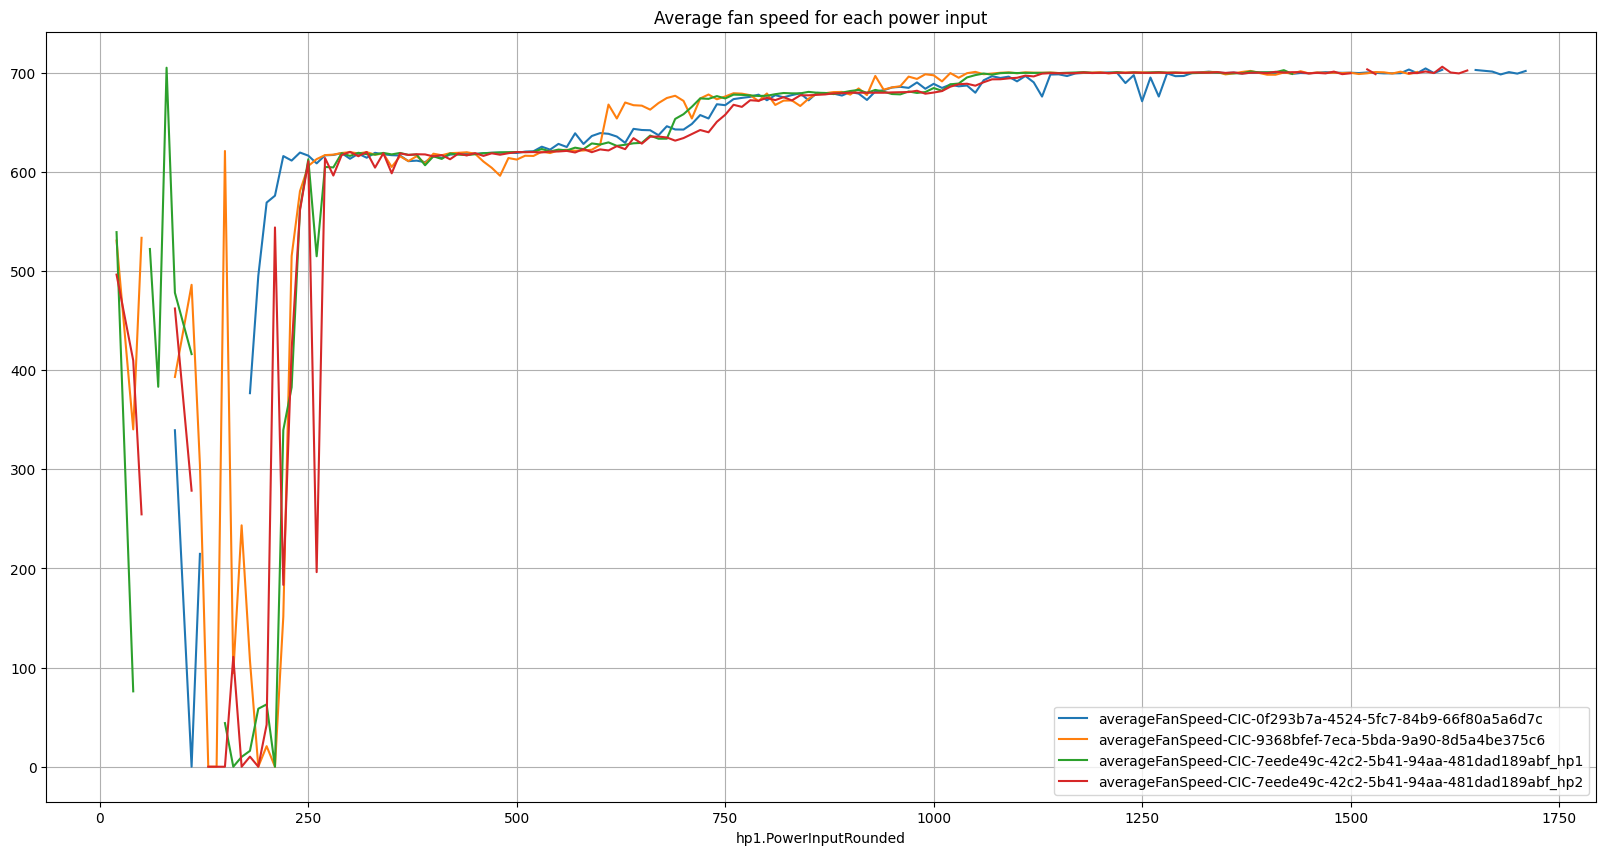

In [19]:
# plot average fan speed for each power input
power_df.plot(x='hp1.PowerInputRounded', figsize=(20,10), title='Average fan speed for each power input')
plt.grid()
plt.show()

In [24]:
power_df['countAbove630'] = power_df['hp1.PowerInputRounded'].apply(lambda x: len(df_test[(df_test['hp1.getFanSpeed']>630) &
                                                                                (df_test['hp1.PowerInputRounded'] == x) &
                                                                                (df_test['system.quattId'] == 'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')]))
power_df['countBelow630'] = power_df['hp1.PowerInputRounded'].apply(lambda x: len(df_test[(df_test['hp1.getFanSpeed']<=630) &
                                                                                (df_test['hp1.PowerInputRounded'] == x) &
                                                                                (df_test['system.quattId'] == 'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')]))
power_df['fractionAbove'] = power_df['countAbove630'] / (power_df['countAbove630'] + power_df['countBelow630'])
power_df['fractionBelow'] = power_df['countBelow630'] / (power_df['countAbove630'] + power_df['countBelow630'])
power_df.set_index('hp1.PowerInputRounded', inplace=True)
power_df[['fractionAbove', 'fractionBelow']].plot.bar(stacked=True, figsize=[20,10])

<Axes: xlabel='hp1.PowerInputRounded'>

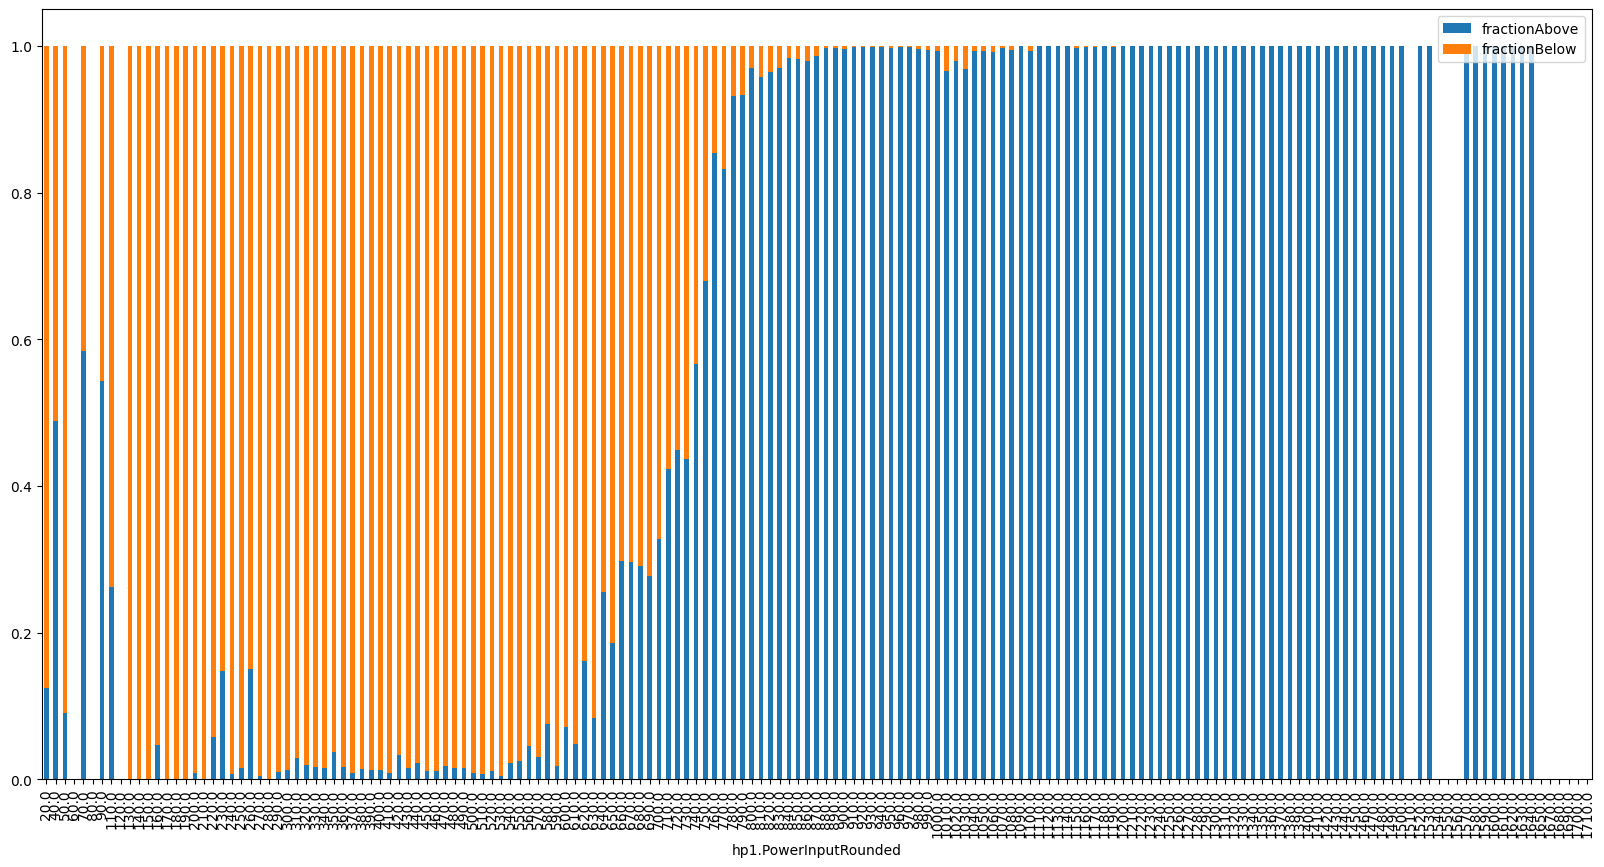

In [26]:
power_df2 = pd.DataFrame(powers, columns=['hp1.PowerInputRounded'])
power_df2['countAbove630'] = power_df2['hp1.PowerInputRounded'].apply(lambda x: len(df_test[(df_test['hp1.getFanSpeed']>630) &
                                                                                (df_test['hp1.PowerInputRounded'] == x) &
                                                                                (df_test['system.quattId'] == 'CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp2')]))
power_df2['countBelow630'] = power_df2['hp1.PowerInputRounded'].apply(lambda x: len(df_test[(df_test['hp1.getFanSpeed']<=630) &
                                                                                (df_test['hp1.PowerInputRounded'] == x) &
                                                                                (df_test['system.quattId'] == 'CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp2')]))
power_df2['fractionAbove'] = power_df2['countAbove630'] / (power_df2['countAbove630'] + power_df2['countBelow630'])
power_df2['fractionBelow'] = power_df2['countBelow630'] / (power_df2['countAbove630'] + power_df2['countBelow630'])
power_df2.set_index('hp1.PowerInputRounded', inplace=True)
power_df2[['fractionAbove', 'fractionBelow']].plot.bar(stacked=True, figsize=[20,10])

<Axes: xlabel='hp1.PowerInputRounded'>

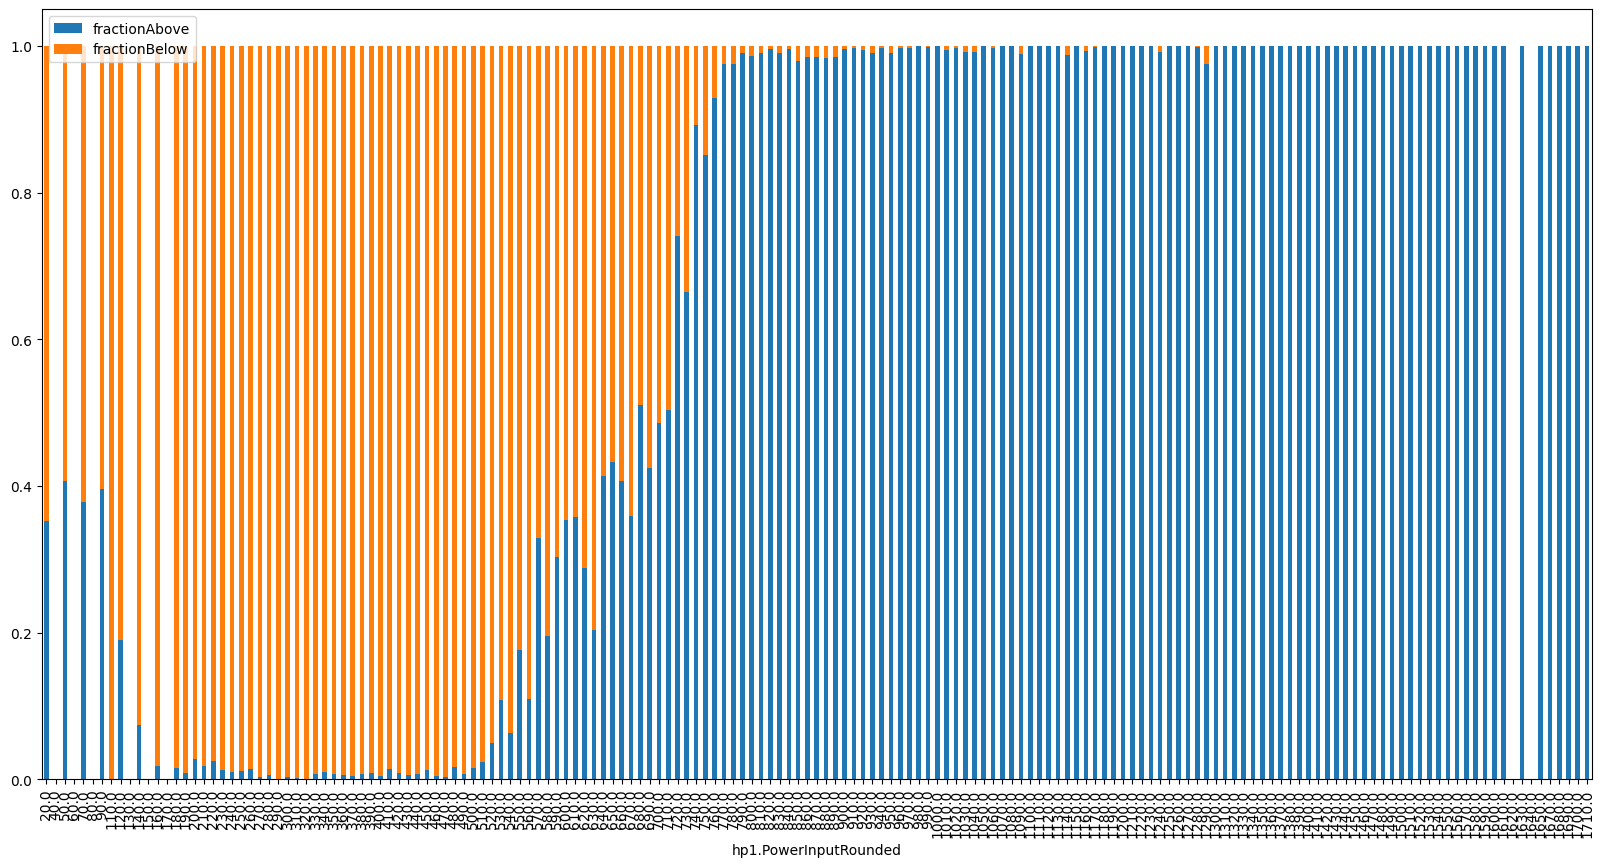

In [25]:
power_df2 = pd.DataFrame(powers, columns=['hp1.PowerInputRounded'])
power_df2['countAbove630'] = power_df2['hp1.PowerInputRounded'].apply(lambda x: len(df_test[(df_test['hp1.getFanSpeed']>630) &
                                                                                (df_test['hp1.PowerInputRounded'] == x) &
                                                                                (df_test['system.quattId'] == 'CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp2')]))
power_df2['countBelow630'] = power_df2['hp1.PowerInputRounded'].apply(lambda x: len(df_test[(df_test['hp1.getFanSpeed']<=630) &
                                                                                (df_test['hp1.PowerInputRounded'] == x) &
                                                                                (df_test['system.quattId'] == 'CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp2')]))
power_df2['fractionAbove'] = power_df2['countAbove630'] / (power_df2['countAbove630'] + power_df2['countBelow630'])
power_df2['fractionBelow'] = power_df2['countBelow630'] / (power_df2['countAbove630'] + power_df2['countBelow630'])
power_df2.set_index('hp1.PowerInputRounded', inplace=True)
power_df2[['fractionAbove', 'fractionBelow']].plot.bar(stacked=True, figsize=[20,10])

<Axes: xlabel='hp1.PowerInput', ylabel='hp1.getFanSpeed'>

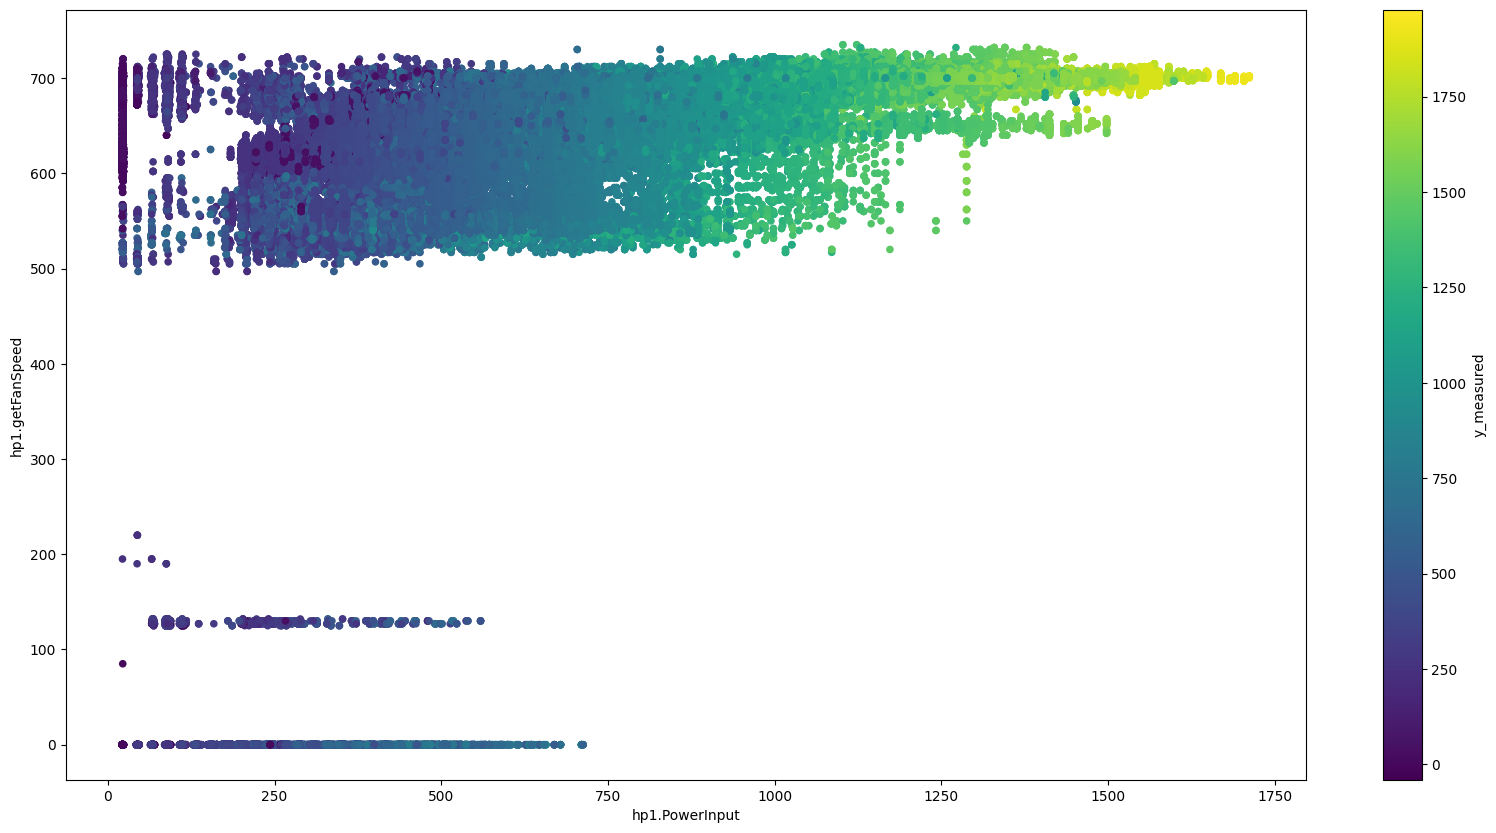

In [28]:
energy_df[energy_df['hp1.PowerInput']>0].plot.scatter(x='hp1.PowerInput', y='hp1.getFanSpeed', c='y_measured', figsize=[20,10])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


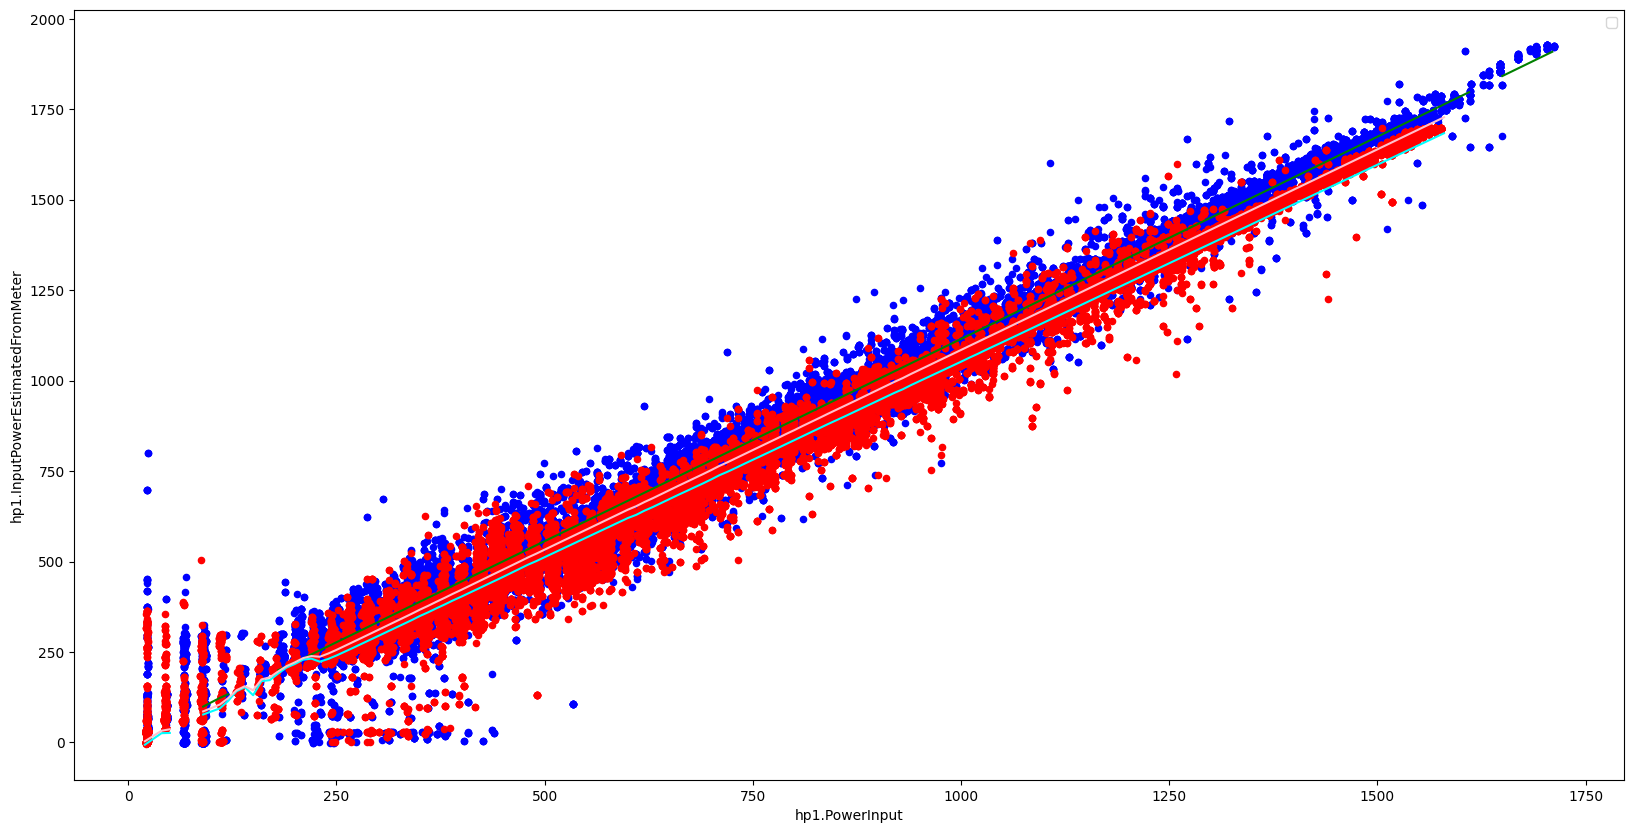

In [23]:
energy_df['hp1.InputPowerEstimatedFromMeter'] = energy_df['y_measured'] - 5 - 155*energy_df['hp1.bottomPlateHeaterEnable']
ax = energy_df[(energy_df['hp1.PowerInput']>0) &
          (energy_df['system.quattId'] == 'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')].plot.scatter(x='hp1.PowerInput', 
                                                                                                    y='hp1.InputPowerEstimatedFromMeter', 
                                                                                                    c='blue', figsize=[20,10])
energy_df[(energy_df['hp1.PowerInput']>0) &
          (energy_df['system.quattId'] == 'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6')].plot.scatter(x='hp1.PowerInput', 
                                                                                                    y='hp1.InputPowerEstimatedFromMeter', 
                                                                                                    c='red', figsize=[20,10], ax=ax)
ax.plot(power_df['hp1.PowerInputRounded'], 1.118220*power_df['hp1.PowerInputRounded'] -0.004676*power_df['averageFanSpeed-CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c'], c='green')
ax.plot(power_df['hp1.PowerInputRounded'], 1.089138*power_df['hp1.PowerInputRounded'] -0.053018*power_df['averageFanSpeed-CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6'], c='cyan')
ax.plot(power_df['hp1.PowerInputRounded'], 1.109449*power_df['hp1.PowerInputRounded'] -0.035745*power_df['averageFanSpeed-CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6'], c='pink')
plt.legend()

In [43]:
energy_train.iloc[6::10][(energy_train.iloc[6::10]['y_measured']>10) & (energy_train[6::10]['qc.hp1PowerInput']<10)]

,time.ts,system.quattId,system.externalElectricityMeterEnergy,system.externalElectricityMeterPower,hp1.circulatingPumpDutyCycle,qc.externalElectricityMeterEnergy,qc.externalElectricityMeterPower,y_measured,qc.hp1PowerInput,hp1.bottomPlateHeaterEnable,hp1.getFanSpeed
5886,1680313093215,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,112.267998,56.717915,32.0,NaN,NaN,12.977915,0.0,0.0,0.0
5896,1680313103228,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,112.268997,56.904930,33.0,NaN,NaN,12.164930,0.0,0.0,0.0
25836,1680333072392,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,113.555000,56.297527,31.0,NaN,NaN,13.557527,0.0,0.0,0.0
25846,1680333082398,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,113.556000,55.783371,31.0,NaN,NaN,13.043371,0.0,0.0,0.0
25956,1680333192550,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,113.556999,50.040199,0.0,NaN,NaN,38.300199,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7907386,1681617492678,CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp2,NaN,NaN,12.0,136.292007,23.256638,11.256638,0.0,0.0,0.0
7930906,1681641064033,CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp2,NaN,NaN,12.0,137.227997,45.587685,33.587685,0.0,0.0,632.0
7930916,1681641074041,CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp2,NaN,NaN,12.0,137.227997,40.726376,28.726376,0.0,0.0,632.0
7930966,1681641124145,CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp2,NaN,NaN,12.0,137.227997,23.267172,11.267172,0.0,0.0,0.0


<Axes: xlabel='qc.hp1PowerInput', ylabel='y_measured'>

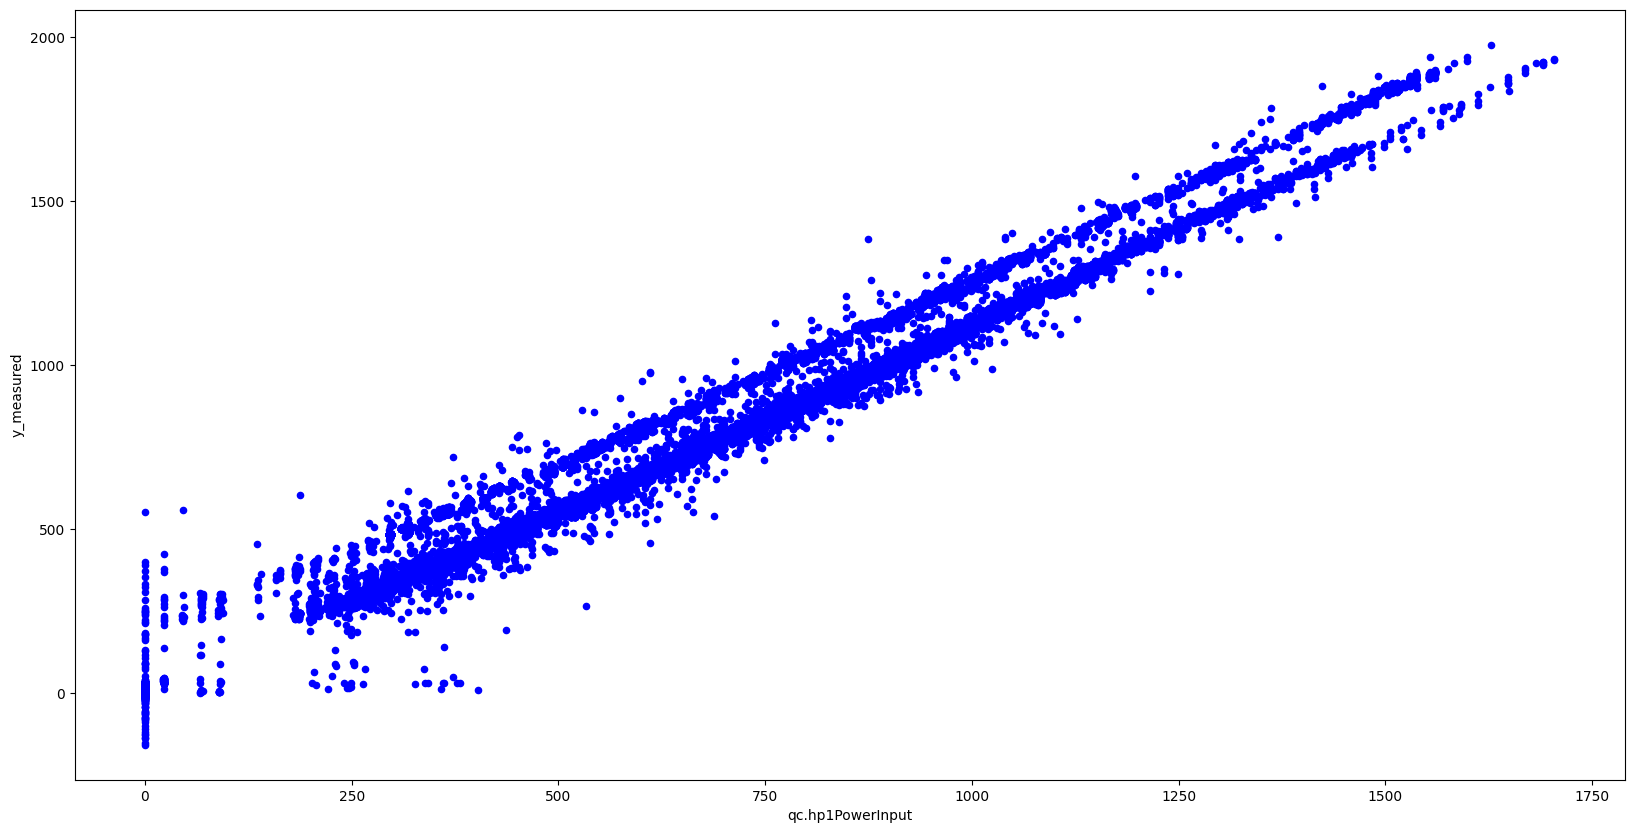

In [90]:
# CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c
# energy_train['y_measured'] = y_train
# energy_train['qc.hp1PowerInput'] = X_train['qc.hp1PowerInput']
# energy_train['hp1.bottomPlateHeaterEnable'] = X_train['hp1.bottomPlateHeaterEnable']
# energy_train['hp1.getFanSpeed'] = X_train['hp1.getFanSpeed']

energy_df[(energy_df['system.quattId'] == 'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c') &
          (energy_df['timeCalculated'] == 0) &
          (energy_df['timeDelta[S]'] < 1.9)].plot.scatter(x='qc.hp1PowerInput', 
                                                            y='y_measured', 
                                                            c='blue', figsize=[20,10])

In [92]:
# energy_df['timeCalculated'] = round((energy_df['time.ts']-1680307203390)/1000,0)%10 #[energy_df['system.quattId'] == 'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c'][:20]
energy_df[(energy_df['qc.hp1PowerInput']==0) & (energy_df['y_measured']>100)]

,time.ts,system.quattId,system.externalElectricityMeterEnergy,system.externalElectricityMeterPower,hp1.circulatingPumpDutyCycle,y_measured,qc.hp1PowerInput,hp1.bottomPlateHeaterEnable,hp1.getFanSpeed,y_predictedHpSpecific,...,predictedPower,predictedEnergy[kWh],measuredEnergy[kWh],totalPredictedEnergy[kWh],totalMeasuredEnergy[kWh],totalMeterEnergy[kWh],predictedPowerHpSpecific,predictedEnergyHpSpecific[kWh],totalPredictedEnergyHpSpecific[kWh],timeCalculated
18367,1680325581469,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,79.709000,274.376892,10.0,254.306892,0.0,0.0,130.0,3.296106,...,20.495274,0.000006,0.000076,0.078687,0.079923,0.080002,23.366106,0.000006,0.075453,8.0
38494,1680345728510,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,82.973000,197.819702,21.0,166.749702,0.0,0.0,130.0,3.296106,...,31.495274,0.000009,0.000055,3.293325,3.343270,3.344002,34.366106,0.000010,3.386461,5.0
38495,1680345729510,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,82.973000,197.819702,21.0,166.749702,0.0,0.0,130.0,3.296106,...,31.495274,0.000009,0.000055,3.293334,3.343325,3.344002,34.366106,0.000010,3.386471,6.0
56298,1680363549618,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,83.783997,275.611206,21.0,244.541206,0.0,0.0,0.0,4.438471,...,36.142131,0.000010,0.000077,4.090862,4.153221,4.154999,35.508471,0.000010,4.215299,6.0
61003,1680368258856,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,83.838997,291.353027,9.0,272.283027,0.0,0.0,127.0,3.322468,...,19.602509,0.000005,0.000081,4.146135,4.209589,4.209999,22.392468,0.000006,4.271884,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15827520,1682938593944,CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp2,216.783997,133.306198,12.0,121.306198,0.0,0.0,0.0,5.049823,...,17.072131,0.000005,0.000037,167.436654,170.169758,170.131996,17.049823,0.000005,170.349101,1.0
15827521,1682938594944,CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp2,216.783997,255.723969,12.0,243.723969,0.0,0.0,130.0,0.312895,...,12.425274,0.000003,0.000071,167.436657,170.169829,170.131996,12.312895,0.000003,170.349104,2.0
15827522,1682938595947,CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp2,216.783997,255.723969,12.0,243.723969,0.0,0.0,130.0,0.312895,...,12.425274,0.000003,0.000071,167.436661,170.169901,170.131996,12.312895,0.000003,170.349108,3.0
15827523,1682938596948,CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp2,216.783997,296.087891,12.0,284.087891,0.0,0.0,130.0,0.312895,...,12.425274,0.000003,0.000082,167.436664,170.169983,170.131996,12.312895,0.000003,170.349111,4.0


In [88]:
energy_df[:20]

,time.ts,system.quattId,system.externalElectricityMeterEnergy,system.externalElectricityMeterPower,hp1.circulatingPumpDutyCycle,y_measured,qc.hp1PowerInput,hp1.bottomPlateHeaterEnable,hp1.getFanSpeed,y_predictedHpSpecific,...,predictedPower,predictedEnergy[kWh],measuredEnergy[kWh],totalPredictedEnergy[kWh],totalMeasuredEnergy[kWh],totalMeterEnergy[kWh],predictedPowerHpSpecific,predictedEnergyHpSpecific[kWh],totalPredictedEnergyHpSpecific[kWh],timeCalculated
0,1680307196384,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,79.628998,16.434578,0.0,6.364578,0.0,0.0,0.0,4.438471,...,15.142131,NaN,NaN,NaN,NaN,0.0,14.508471,NaN,NaN,3.0
1,1680307197385,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,79.628998,16.434578,0.0,6.364578,0.0,0.0,0.0,4.438471,...,15.142131,0.000004,0.000005,0.000004,0.000005,0.0,14.508471,0.000004,0.000004,4.0
2,1680307198387,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,79.628998,16.434578,0.0,6.364578,0.0,0.0,0.0,4.438471,...,15.142131,0.000004,0.000005,0.000008,0.000009,0.0,14.508471,0.000004,0.000008,5.0
3,1680307199387,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,79.628998,16.434578,0.0,6.364578,0.0,0.0,0.0,4.438471,...,15.142131,0.000004,0.000005,0.000013,0.000014,0.0,14.508471,0.000004,0.000012,6.0
4,1680307200388,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,79.628998,16.434578,0.0,6.364578,0.0,0.0,0.0,4.438471,...,15.142131,0.000004,0.000005,0.000017,0.000018,0.0,14.508471,0.000004,0.000016,7.0
5,1680307201389,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,79.628998,16.434578,0.0,6.364578,0.0,0.0,0.0,4.438471,...,15.142131,0.000004,0.000005,0.000021,0.000023,0.0,14.508471,0.000004,0.000020,8.0
6,1680307202389,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,79.628998,16.434578,0.0,6.364578,0.0,0.0,0.0,4.438471,...,15.142131,0.000004,0.000005,0.000025,0.000027,0.0,14.508471,0.000004,0.000024,9.0
7,1680307203390,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,79.628998,16.401917,0.0,6.331917,0.0,0.0,0.0,4.438471,...,15.142131,0.000004,0.000005,0.000029,0.000032,0.0,14.508471,0.000004,0.000028,0.0
8,1680307204393,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,79.628998,16.401917,0.0,6.331917,0.0,0.0,0.0,4.438471,...,15.142131,0.000004,0.000005,0.000034,0.000037,0.0,14.508471,0.000004,0.000032,1.0
9,1680307205393,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,79.628998,16.401917,0.0,6.331917,0.0,0.0,0.0,4.438471,...,15.142131,0.000004,0.000005,0.000038,0.000041,0.0,14.508471,0.000004,0.000036,2.0


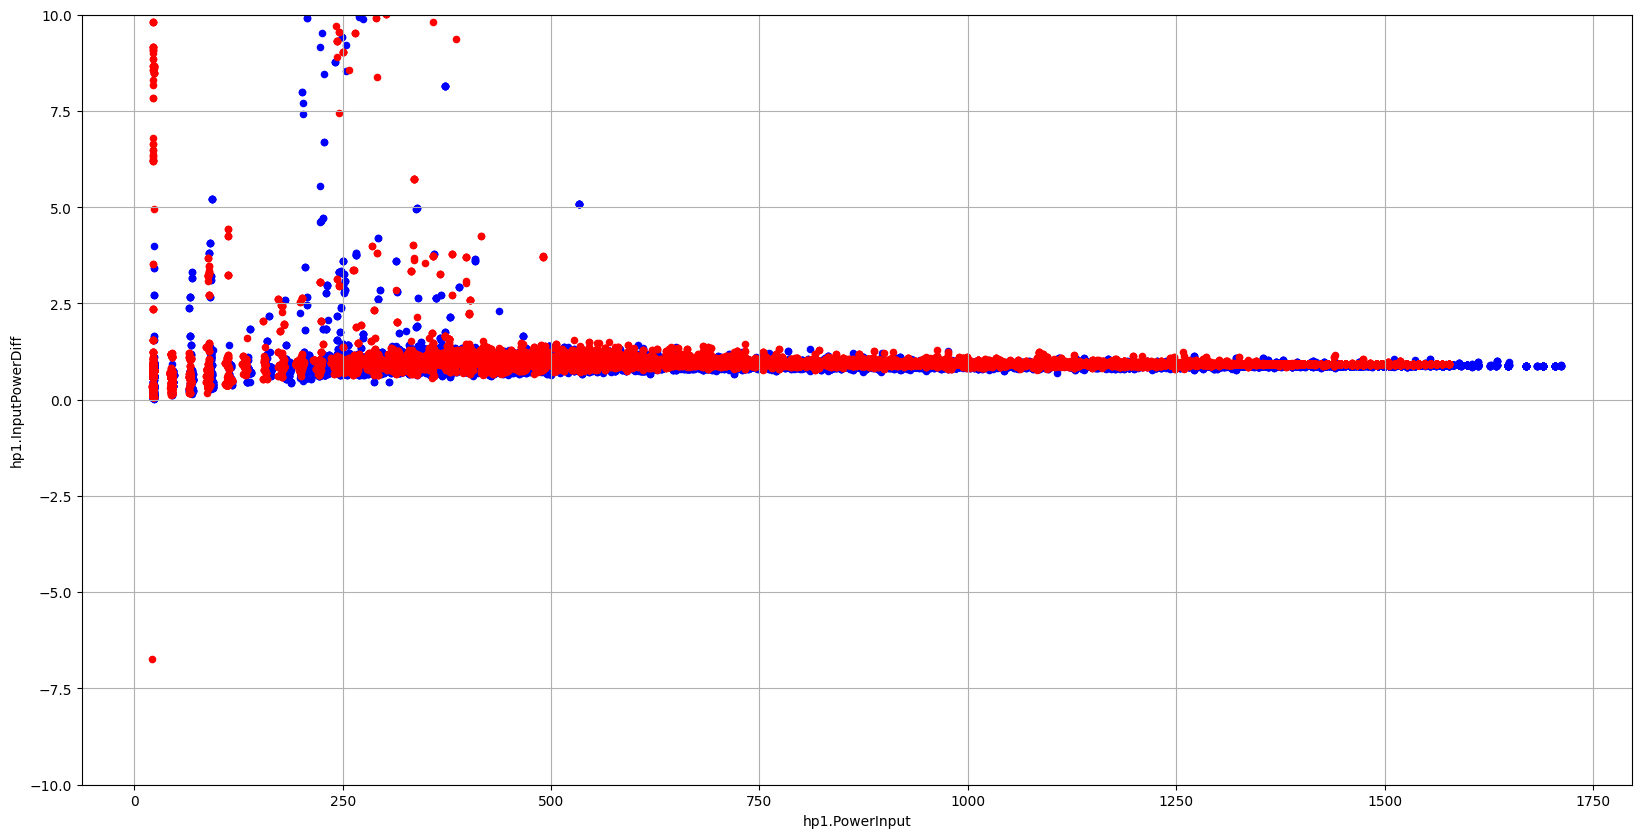

In [13]:
energy_df['hp1.InputPowerDiff'] = energy_df['hp1.PowerInput'] / energy_df['hp1.InputPowerEstimatedFromMeter']
ax = energy_df[(energy_df['hp1.PowerInput']>0) &
          (energy_df['system.quattId'] == 'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')].plot.scatter(x='hp1.PowerInput', 
                                                                                                    y='hp1.InputPowerDiff', 
                                                                                                    c='blue', figsize=[20,10])
energy_df[(energy_df['hp1.PowerInput']>0) &
          (energy_df['system.quattId'] == 'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6')].plot.scatter(x='hp1.PowerInput', 
                                                                                                    y='hp1.InputPowerDiff', 
                                                                                                    c='red', figsize=[20,10], ax=ax)
ax.set_ylim([-10,10])
plt.grid()

In [14]:
energy_df['hp1.PowerInputComponentGeneral'] = energy_df['hp1.PowerInput'] * df_linreg['qc.hp1PowerInput'][0]
energy_df['hp1.getFanSpeedComponentGeneral'] = energy_df['hp1.getFanSpeed'] * df_linreg['hp1.getFanSpeed'][0]
energy_df['hp1.bottomPlateHeaterEnableComponentGeneral'] = energy_df['hp1.bottomPlateHeaterEnable'] * df_linreg['hp1.bottomPlateHeaterEnable'][0]

def get_specific_power_input(row):
    if row['system.quattId'] == 'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c':
        return row['hp1.PowerInput'] * df_linreg['qc.hp1PowerInput'][0]
    elif row['system.quattId'] == 'CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp1':
        return row['hp1.PowerInput'] * df_linreg['qc.hp1PowerInput'][1]
    elif row['system.quattId'] == 'CIC-7eede49c-42c2-5b41-94aa-481dad189abf_hp2':
        return row['hp1.PowerInput'] * df_linreg['qc.hp1PowerInput'][2]
    elif row['system.quattId'] == 'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6':
        return row['hp1.PowerInput'] * df_linreg['qc.hp1PowerInput'][3]
    elif row['system.quattId'] == 'CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp1':
        return row['hp1.PowerInput'] * df_linreg['qc.hp1PowerInput'][4]
    elif row['system.quattId'] == 'CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea_hp2':
        return row['hp1.PowerInput'] * df_linreg['qc.hp1PowerInput'][5]
    

    # return df_linreg[df_linreg['source']==row['system.quattId']]['qc.hp1PowerInput'] * row['hp1.PowerInput']
energy_df['hp1.PowerInputComponentSpecific'] = energy_df.apply(get_specific_power_input, axis=1)




KeyboardInterrupt: 

In [ ]:
def get_specific_fan_speed(row):
    return df_linreg[df_linreg['source']==row['system.quattId']]['hp1.getFanSpeed'] * row['hp1.getFanSpeed']
energy_df['hp1.getFanSpeedComponentSpecific'] = energy_df.apply(get_specific_fan_speed, axis=1)

def get_specific_bottom_plate_heater(row):
    return df_linreg[df_linreg['source']==row['system.quattId']]['hp1.bottomPlateHeaterEnable'] * row['hp1.bottomPlateHeaterEnable']
energy_df['hp1.bottomPlateHeaterEnableComponentSpecific'] = energy_df.apply(get_specific_bottom_plate_heater, axis=1)

In [46]:
print(predictedErrors)
print(measuredErrors)

# with heaterCoilEnable flag
# [-0.024905646007376606, 0.0033161227248382397, 0.01991657076384462, 0.029099847442769503, 0.02948865514784634, -0.015878284072193737]
# [0.00448967675009791, 0.010720602458825057, 0.011855658969480458, -0.00014252867475337088, 0.0009059461649539374, 0.000224838906963669]
# with hand calculated values: 1 / (1.11 + 4.63 (X - 4))
# [-0.02536210614307158, 0.002982311994032791, 0.019952209976748063, 0.03122161766859788, 0.03367481238976836, -0.00923144195908747]
# [0.00448967675009791, 0.010720602458825057, 0.011855658969480458, -0.00014252867475337088, 0.0009059461649539374, 0.000224838906963669]
# # with Curve fit
# [-0.025361286856920733, 0.0029149474746012942, 0.01983684801416725, 0.03144477520077903, 0.03367013479207232, -0.009313874385095842]
# [0.00448967675009791, 0.010720602458825057, 0.011855658969480458, -0.00014252867475337088, 0.0009059461649539374, 0.000224838906963669]
print(np.mean([-0.024905646007376606, 0.0033161227248382397, 0.01991657076384462, 0.029099847442769503, 0.02948865514784634, -0.015878284072193737]))
print(np.mean([-0.02536210614307158, 0.002982311994032791, 0.019952209976748063, 0.03122161766859788, 0.03367481238976836, -0.00923144195908747]))
print(np.mean([-0.025361286856920733, 0.0029149474746012942, 0.01983684801416725, 0.03144477520077903, 0.03367013479207232, -0.009313874385095842]))


[-0.025361924902757526, 0.002961876284573119, 0.019915311056286186, 0.03128445737510232, 0.03367084927639827, -0.009258150630941918]
[0.00448967675009791, 0.010720602458825057, 0.011855658969480458, -0.00014252867475337088, 0.0009059461649539374, 0.000224838906963669]
0.00683954433328806
0.008872900654498007
0.008865257373267219


### link between bottomPlateHeaterEnable and outsideTemperature

Text(0, 0.5, 'outside temperature')

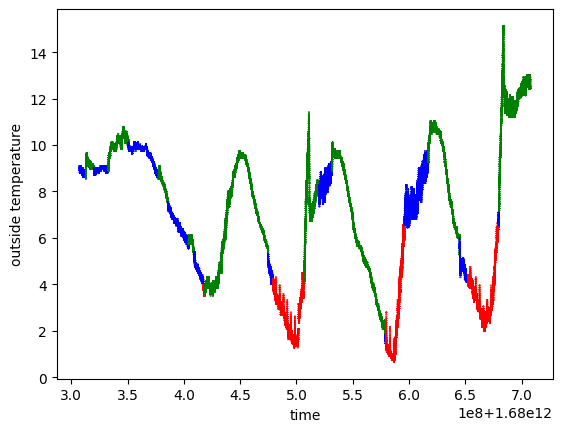

In [216]:
# plot hp1.outsideTemperature vs. time color coding when bottomPlateHeaterEnable is on
# P(t) = 1.107 * hp1.inputPower -0.041 * hp1.getFanSpeed + bpH(t) * 156.56 + cH(t) * 40 + 5.066
# bpH(t) = 1 if (bpH(t-1) = 1 and Toutside < 7 or bpH(t-1) = 0 and Toutside < 4) else 0
# red = heater on
# blue = heater off
# green = heatpump off
# from the graph the heater coil seems to start at around 4 degrees, and then stay on untill 7 degrees
colors = ['red' if (coil == 1)  else 'blue' if power>0 else 'green' for coil, power in zip(temp_df['hp1.bottomPlateHeaterEnable'],temp_df['hp1.power'])]
plt.scatter(temp_df[:400000]['time.ts'], temp_df[:400000]['hp1.temperatureOutside'], c=colors[:400000], s=0.1)
plt.xlabel('time')
plt.ylabel('outside temperature')
plt.show()


[-12.46274134  13.78467009   2.98732452]


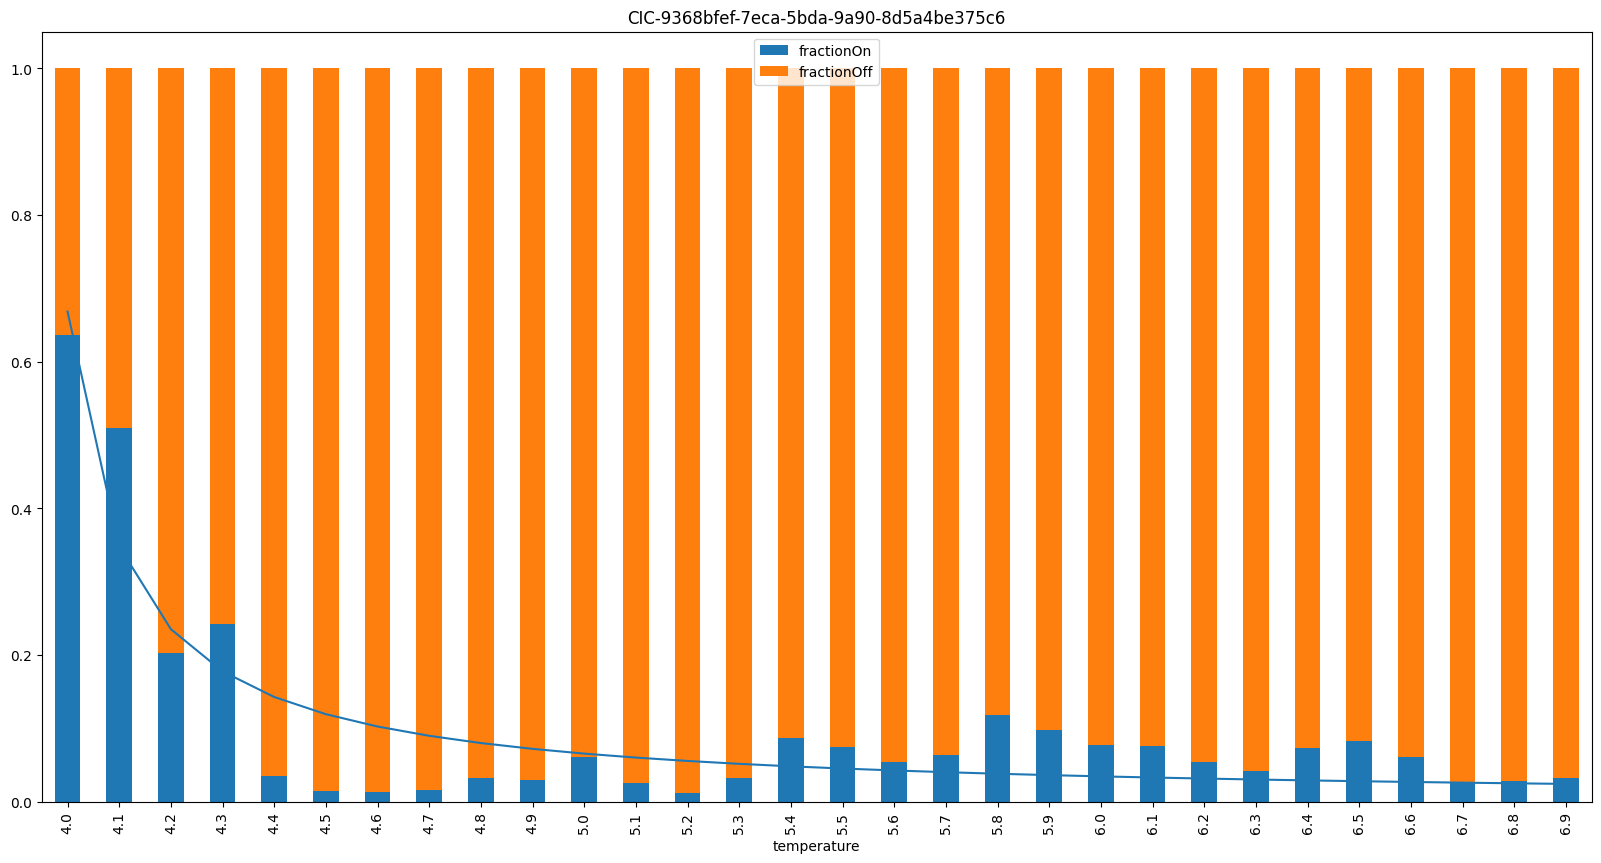

[-2.65667255 27.16255698  3.86206156]


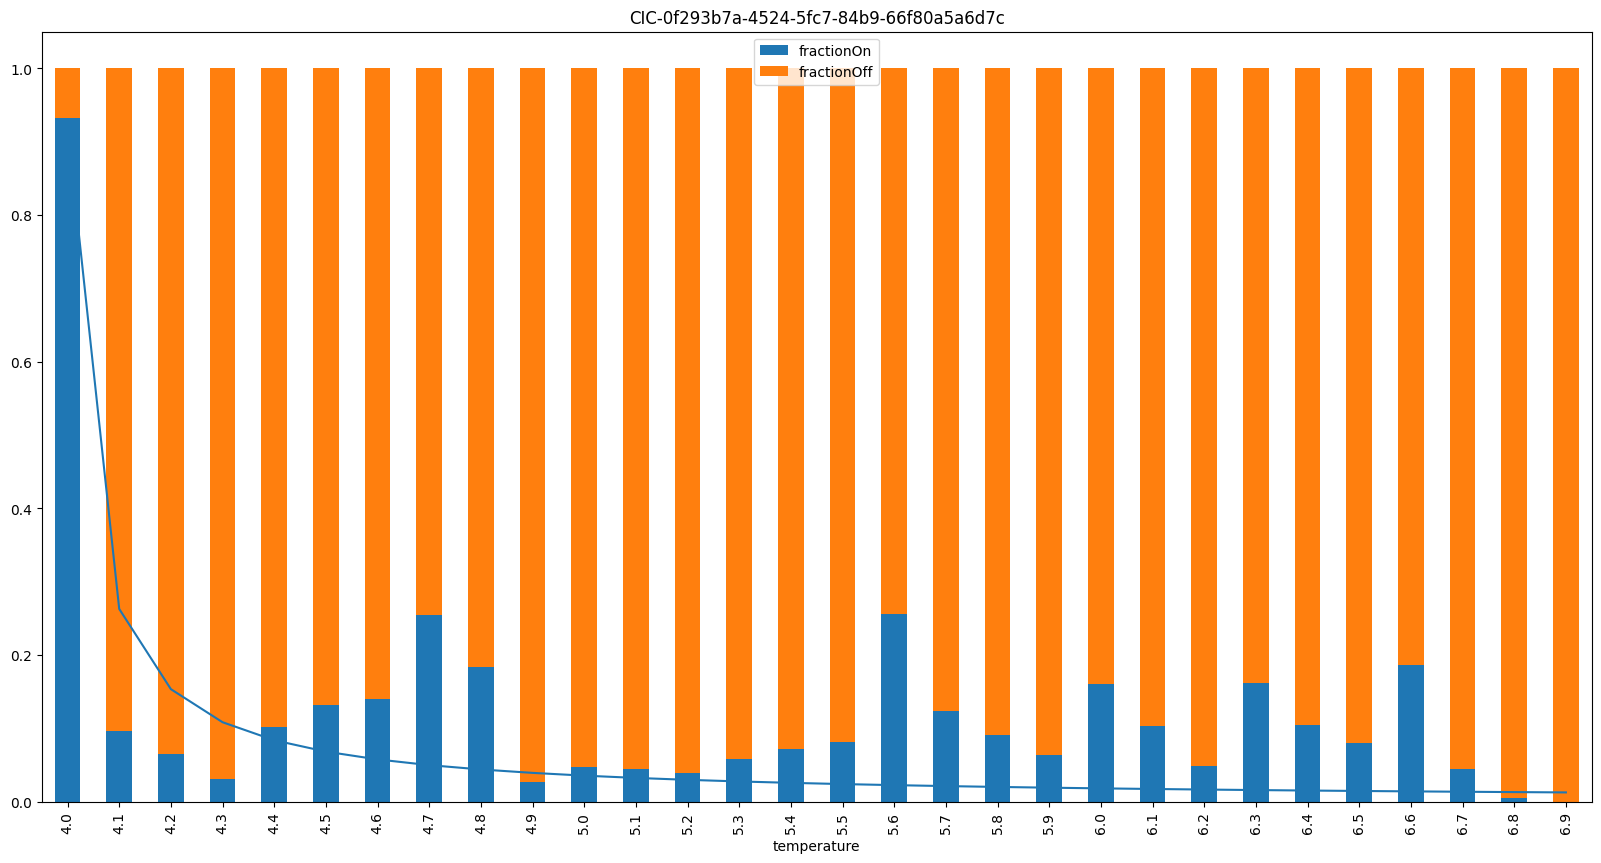

[6.77822465 3.05020829 5.7125179 ]


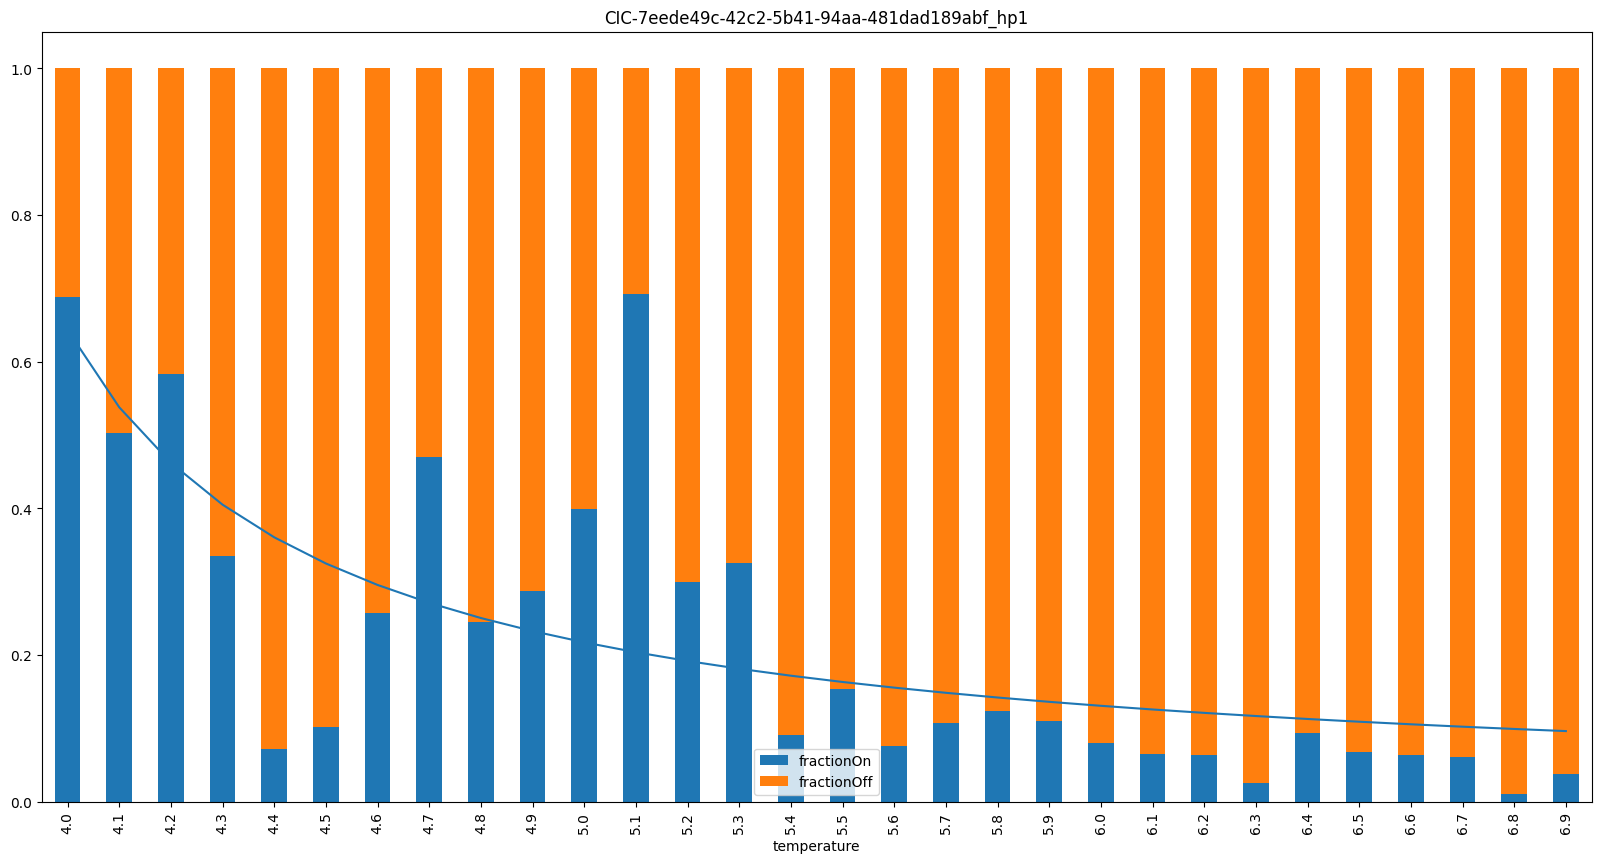

[7.73741803 6.17922194 4.93516475]


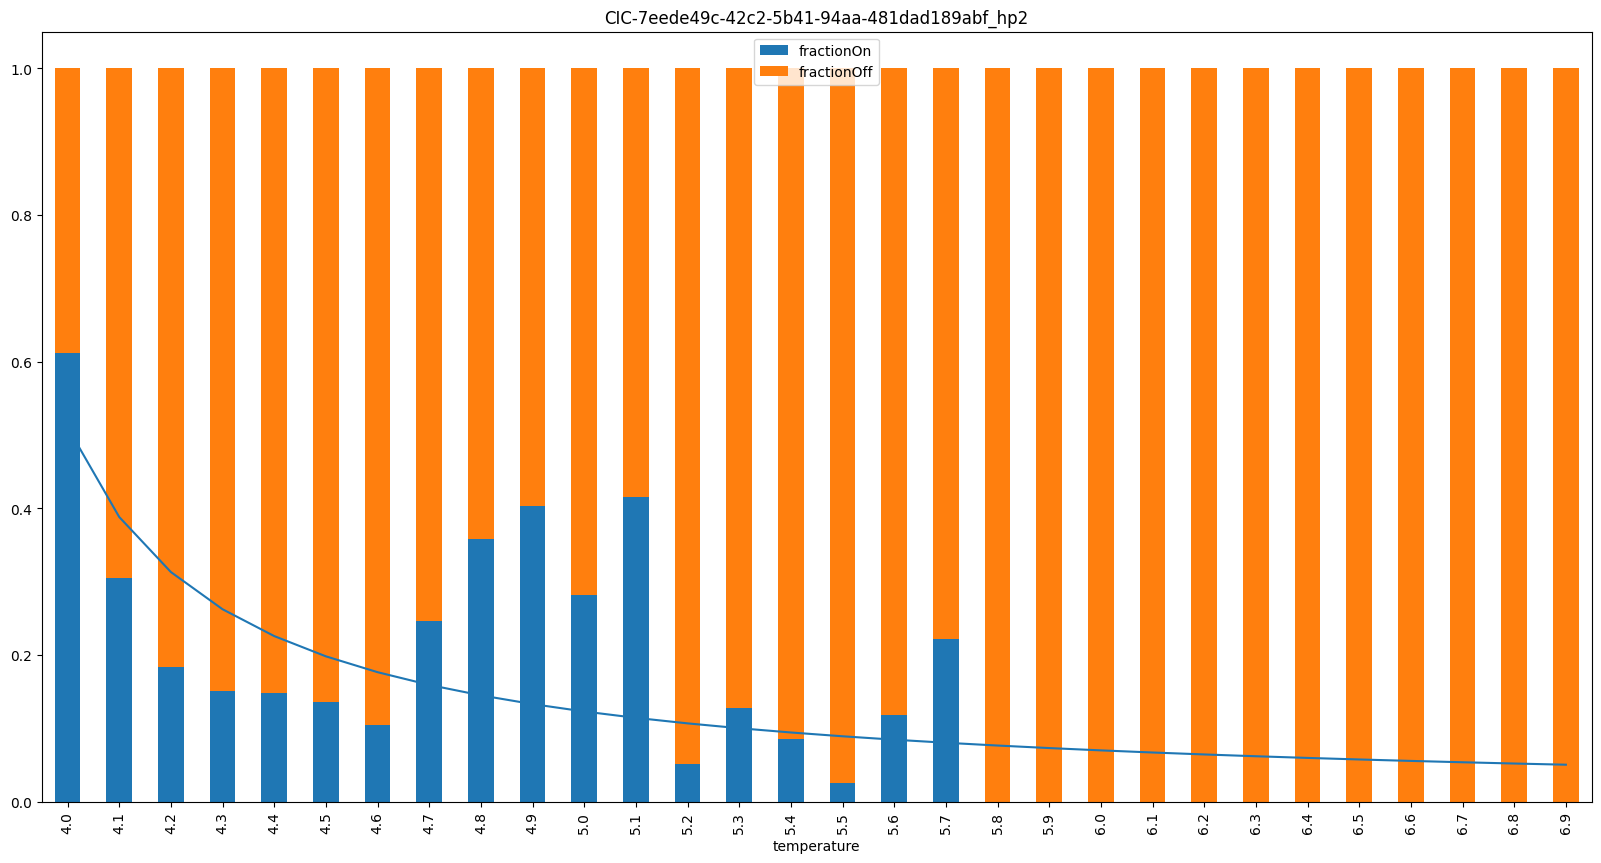

[4.54226709 5.72864621 4.57067562]


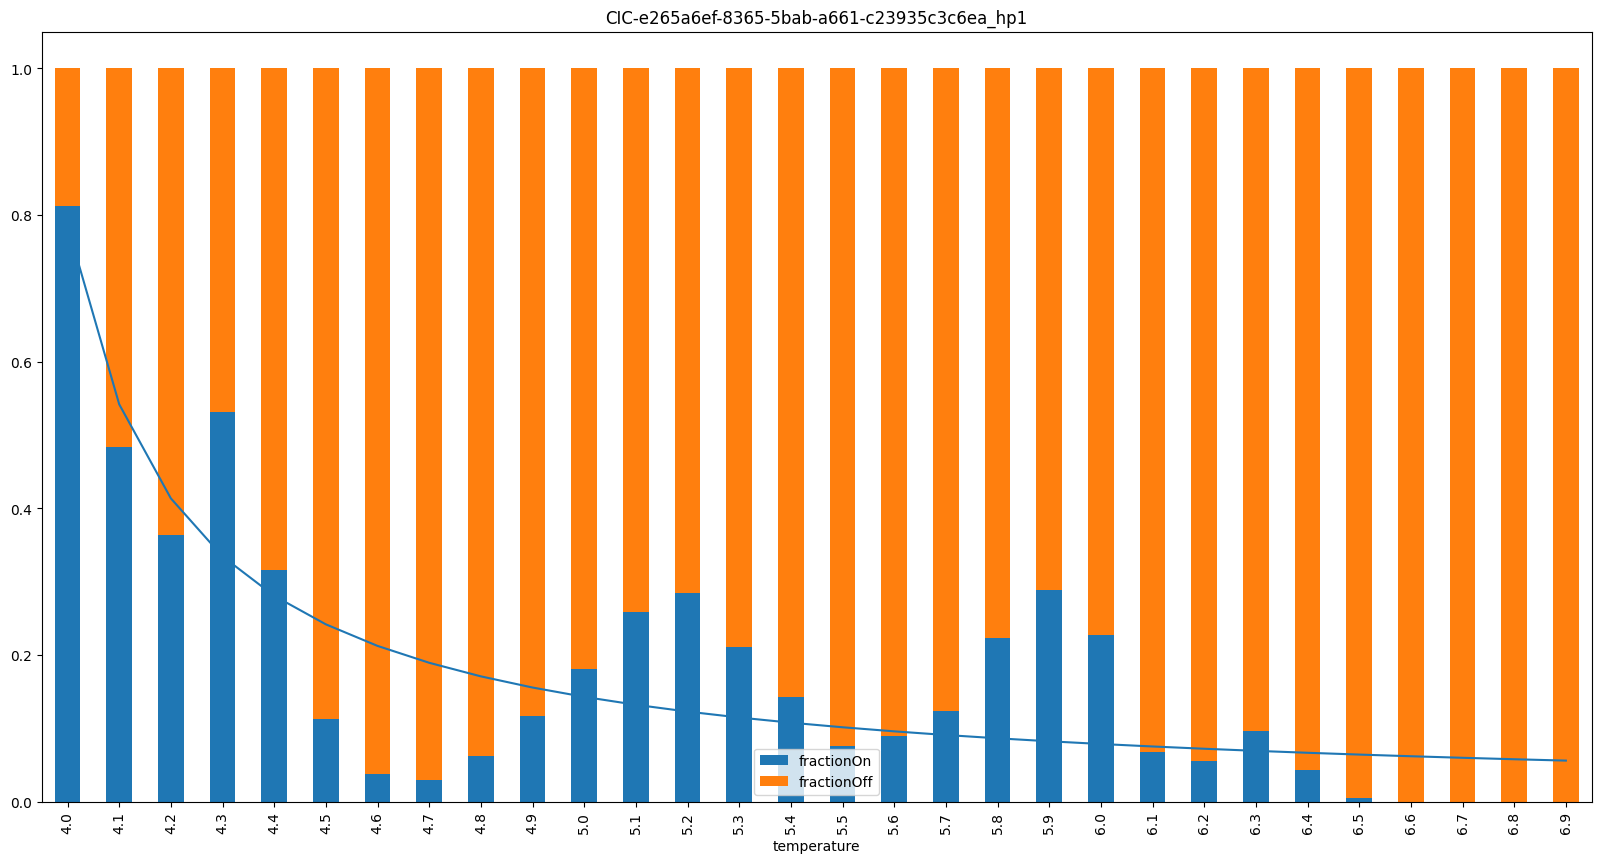

[-70.9463338   14.12525649  -1.16704625]


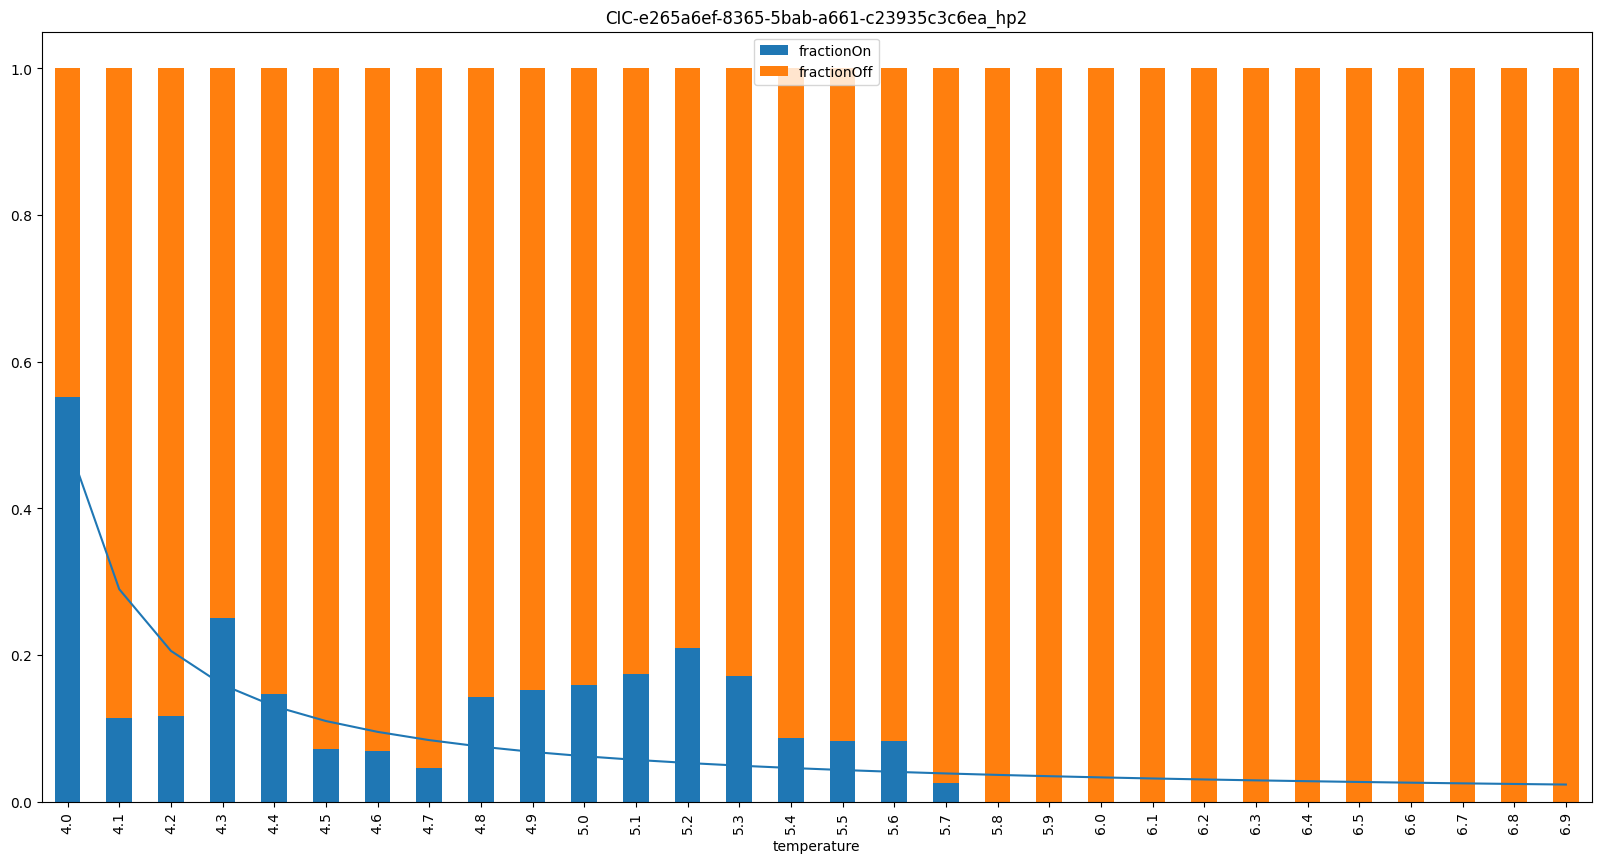

In [518]:
# comparison of bar plots for each seperate cic
X_test['hp1.temperatureOutsideRounded'] = X_test['hp1.temperatureOutside'].apply(lambda x: round(x,1))
energyX_test = energy_test.join(X_test)
for cic in energyX_test['system.quattId'].unique():
    heatcoil_df = pd.DataFrame(temperatures, columns=['temperature'])

    heatcoil_df['countHeatCoilOn'] = heatcoil_df['temperature'].apply(lambda x: len(energyX_test[(energyX_test['qc.hp1PowerInput']>0) &
                                                                                            (energyX_test['hp1.temperatureOutsideRounded'] == x) &
                                                                                            (energyX_test['hp1.bottomPlateHeaterEnable'] == 1) &
                                                                                            (energyX_test['system.quattId'] == cic)]))
    heatcoil_df['countHeatCoilOff'] = heatcoil_df['temperature'].apply(lambda x: len(energyX_test[(energyX_test['qc.hp1PowerInput']>0) &
                                                                                            (energyX_test['hp1.temperatureOutsideRounded'] == x) &
                                                                                            (energyX_test['hp1.bottomPlateHeaterEnable'] == 0) &
                                                                                            (energyX_test['system.quattId'] == cic)]))
    heatcoil_df['fractionOn'] = heatcoil_df['countHeatCoilOn'] / (heatcoil_df['countHeatCoilOn'] + heatcoil_df['countHeatCoilOff'])
    heatcoil_df['fractionOff'] = heatcoil_df['countHeatCoilOff'] / (heatcoil_df['countHeatCoilOn'] + heatcoil_df['countHeatCoilOff'])

    # set temperature values as index
    heatcoil_df.set_index('temperature', inplace=True)

    def func(x, a, b, c):
        return 1 / (a + b*(x-c))
    popt, pcov = curve_fit(func, heatcoil_df.index, heatcoil_df['fractionOn'])
    print(popt)

    # create absolute and relative stacked bar plots
    ax2 = heatcoil_df[['fractionOn', 'fractionOff']].plot.bar(stacked=True, figsize=[20,10])
    ax2.plot(10*(heatcoil_df.index-4), (1/(popt[0] + popt[1]*(heatcoil_df.index-popt[2]))).tolist())
    plt.title(cic)
    # ax2.plot(heatcoil_df.index.tolist(), (1/(1.11 + 4.63*(heatcoil_df.index-4))).tolist())
    plt.show()

In [70]:
quatt_s3_client = create_s3_client(aws_profile="nout_prod")

# Load training data from s3 into a pandas DataFrame
cics = [
        'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6', 
        'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c',
        'CIC-7eede49c-42c2-5b41-94aa-481dad189abf', # 8kW hp1
        'CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea', # 8kW
        'CIC-7eede49c-42c2-5b41-94aa-481dad189abf', # 8kW
        'CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea' # 8kW
        ]
# Compensating for 11 W of energy consumption by the external electricity meter 
# Estimate the model different cics and compare the intercept to estimate the offset
offsets = [
           0,
           0,
           0,
           0,
           0,
           0
           ]
props = [
         {'system': ['externalElectricityMeterPower'],
         'qc': ['hp1PowerInput'],
         'hp1': ['acInputVoltage', 'acInputCurrent', 'getFanSpeed', 'bottomPlateHeaterEnable', 'compressorCrankcaseHeaterEnable', 'circulatingPumpDutyCycle', 'getCirculatingPumpRelay']},
         {'system': ['externalElectricityMeterPower'],
         'qc': ['hp1PowerInput'],
         'hp1': ['acInputVoltage', 'acInputCurrent', 'getFanSpeed', 'bottomPlateHeaterEnable', 'compressorCrankcaseHeaterEnable', 'circulatingPumpDutyCycle', 'getCirculatingPumpRelay']},
         {'qc': ['hp1PowerInput', 'externalElectricityMeterPower'],
         'hp1': ['acInputVoltage', 'acInputCurrent', 'getFanSpeed', 'bottomPlateHeaterEnable', 'compressorCrankcaseHeaterEnable', 'circulatingPumpDutyCycle', 'getCirculatingPumpRelay']},
         {'qc': ['hp1PowerInput', 'externalElectricityMeterPower'],
         'hp1': ['acInputVoltage', 'acInputCurrent', 'getFanSpeed', 'bottomPlateHeaterEnable', 'compressorCrankcaseHeaterEnable', 'circulatingPumpDutyCycle', 'getCirculatingPumpRelay']},
         {'qc': ['externalElectricityMeter2Power'],
         'hp2': ['powerInput', 'acInputVoltage', 'acInputCurrent', 'getFanSpeed', 'bottomPlateHeaterEnable', 'compressorCrankcaseHeaterEnable', 'circulatingPumpDutyCycle', 'getCirculatingPumpRelay']},
         {'qc': ['externalElectricityMeter2Power'],
         'hp2': ['powerInput', 'acInputVoltage', 'acInputCurrent', 'getFanSpeed', 'bottomPlateHeaterEnable', 'compressorCrankcaseHeaterEnable', 'circulatingPumpDutyCycle', 'getCirculatingPumpRelay']}
]
start_date = datetime(2023, 4, 1)
end_date = datetime(2023, 4, 4)

intercepts = []
for cic, offset, prop in zip(cics, offsets, props):
        extract_df = quatt_s3_client.get_cic_data(cic_ids=cic, 
                                                  start_date=start_date, end_date=end_date, 
                                                  filter_objects=['time'], 
                                                  filter_properties=prop,
                                                  cloud_type='production'
                                                 )
        if 'hp2' in prop:
                extract_df['qc.hp1PowerInput'] = extract_df['hp2.powerInput']
                extract_df['qc.externalElectricityMeterPower'] = extract_df['qc.externalElectricityMeter2Power']
                extract_df['hp1.acInputVoltage'] = extract_df['hp2.acInputVoltage']
                extract_df['hp1.acInputCurrent'] = extract_df['hp2.acInputCurrent']
                extract_df['hp1.getFanSpeed'] = extract_df['hp2.getFanSpeed']
                extract_df['hp1.bottomPlateHeaterEnable'] = extract_df['hp2.bottomPlateHeaterEnable']
                extract_df['hp1.compressorCrankcaseHeaterEnable'] = extract_df['hp2.compressorCrankcaseHeaterEnable']
                extract_df['hp1.circulatingPumpDutyCycle'] = extract_df['hp2.circulatingPumpDutyCycle']
                extract_df['hp1.getCirculatingPumpRelay'] = extract_df['hp2.getCirculatingPumpRelay']
                extract_df.drop(['hp2.powerInput', 'qc.externalElectricityMeter2Power', 'hp2.acInputVoltage',
                                'hp2.acInputCurrent','hp2.getFanSpeed','hp2.bottomPlateHeaterEnable','hp2.compressorCrankcaseHeaterEnable',
                                'hp2.circulatingPumpDutyCycle','hp2.getCirculatingPumpRelay'], axis=1, inplace=True)
        X_extract_train, y_extract_train, X_extract_test, y_extract_test = preProcessSplitDataFrame(extract_df, offset)
        # Create a Linear model
        linreg = LinearRegression(fit_intercept=True)

        # Train the model on the training data
        linreg.fit(X_extract_train, y_extract_train)

        # Evaluate
        intercepts.append(linreg.intercept_)
        print("cic id = ", cic)
        print("Coefficients = ", list(linreg.coef_) + [linreg.intercept_])
        y_train_pred = linreg.predict(X_extract_train)
        print("rmse = ", np.sqrt(mean_squared_error(y_extract_train, y_train_pred)))
        # print("mse = ", mean_squared_error(y_train, y_train_pred))
        print("mae = ", mean_absolute_error(y_extract_train, y_train_pred))

print("intercepts = ", intercepts)
print("mean intercept[0:2] = ", np.mean(intercepts[0:2]))
print("mean intercept[2:] = ", np.mean(intercepts[2:]))
# difference in intercepts
print("difference in intercepts = ", np.mean(intercepts[0:2]) - np.mean(intercepts[2:]))



cic id =  CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6
Coefficients =  [1.0476004037871844, -0.01893493545094307, 169.76709082687836, 0.0, 16.842253853977695]
rmse =  7.9856129473862945
mae =  3.9406276747781117
cic id =  CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c
Coefficients =  [1.1242435956052503, -0.036374866620681054, 152.35218089351477, 0.0, 15.177239884722951]
rmse =  10.785040785694678
mae =  3.5985874111473573
cic id =  CIC-7eede49c-42c2-5b41-94aa-481dad189abf
Coefficients =  [1.1213285599080334, -0.035666427179100485, 160.66726903177891, 0.0, 4.891744820873043]
rmse =  16.298928047350987
mae =  5.537046840242883
cic id =  CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea
Coefficients =  [1.118230234270296, -0.072224987428126, 144.06290304400045, 0.0, 5.220130176329377]
rmse =  17.288476812023205
mae =  4.145755511458696
cic id =  CIC-7eede49c-42c2-5b41-94aa-481dad189abf
Coefficients =  [1.1054319535684358, -0.022530779891604222, 160.32511498064073, 0.0, 5.267077539273771]
rmse =  12.8763682

In [2]:
print(15.177239884722951-5.10476884755716)

10.07247103716579
